<a href="https://colab.research.google.com/github/armandossrecife/my_validation3/blob/main/my_analysis_kafka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup do Ambiente de Análise

In [1]:
!rm -rf *.log
!rm -rf *.txt
!rm -rf *.xlsx
!rm -rf my_issues
!rm -rf kafka

In [2]:
print('Install Pydriller.')
!pip install pydriller > install_pydriller.log
print('Install gitpython.')
!pip3 install gitpython > install_gitpython.log
print('Install Jira Python lib.')
!pip install jira > install_jira_python.log
print('All depenpencies installed!')
!cat *.log > install.log
print('Details in install.log')

Install Pydriller.
Install gitpython.
Install Jira Python lib.
All depenpencies installed!
Details in install.log


## Importa bibliotecas necessárias

In [3]:
import os
from datetime import datetime, timedelta
import tqdm
from pydriller import Repository
from jira import JIRA
import pandas as pd
import re
import scipy.stats as stats
import random
import shutil
import time
from matplotlib import pyplot
import cv2

## Variáveis Globais

In [135]:
my_repository = 'kafka'
url_to_repository = 'https://github.com/apache/kafka.git'
os.environ['MY_REPOSITORY'] = url_to_repository

JIRA_SERVER = 'https://issues.apache.org/jira'
ISSUE_TRACKER_PROJECT = 'KAFKA'

# Credentials
os.environ['USERNAME'] = ''
os.environ['PASSWORD'] = ''
username = os.environ.get('USERNAME')
password = os.environ.get('PASSWORD')

path_to_repository = 'kafka'

list_figures = []

arquivos_kafka_by_sysrepoanalysis = ['StreamThread.java','KafkaConsumer.java','KStream.java','KafkaAdminClient.java','StreamTask.java','Fetcher.java','KafkaStreams.java','TaskManager.java','KStreamImpl.java','KafkaProducer.java','StreamsConfig.java','ConsumerCoordinator.java','Sender.java','AbstractCoordinator.java','KTableImpl.java','KTable.java','StreamsPartitionAssignor.java','NetworkClient.java','InternalTopologyBuilder.java','Protocol.java']

lista_arquivos_criticos = ['StreamThread.java', 'KafkaConsumer.java', 'StreamTask.java', 'Fetcher.java', 'KafkaStreams.java','KStreamImpl.java', 'KafkaProducer.java','StreamsConfig.java', 'ConsumerCoordinator.java']

## Clona o Repositório

In [5]:
print(f'Clona o repositório : {url_to_repository}')
!git clone $MY_REPOSITORY

Clona o repositório : https://github.com/apache/kafka.git
Cloning into 'kafka'...
remote: Enumerating objects: 356701, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 356701 (delta 34), reused 166 (delta 21), pack-reused 356492
Receiving objects: 100% (356701/356701), 166.99 MiB | 15.44 MiB/s, done.
Resolving deltas: 100% (172002/172002), done.
Updating files: 100% (5868/5868), done.


In [6]:
!cd kafka && git log --pretty="%H %s" > all_commits_msg.txt
!cd kafka && git log --pretty="%H;%ai;%s" > all_commits_full.txt

# Dados do 1o commit e do ultimo commit
!echo "Último commit: "
!head /content/kafka/all_commits_full.txt -n 1
!echo "Primeiro commit: "
!tail /content/kafka/all_commits_full.txt -n 1

Último commit: 
95f41d59b389b6f25000b7bc4ddb948cfdb90448;2023-11-24 16:41:16 +0100;KIP-978: Allow dynamic reloading of certificates with different DN / SANs (#14756)
Primeiro commit: 
642da2f28c9bc6e373603d6d9119ce33684090f5;2011-08-01 23:41:24 +0000;Initial checkin of Kafka to Apache SVN. This corresponds to https://github.com/kafka-dev/kafka/commit/709afe4ec75489bc00a44335de8821fa726bb97e except that git specific files have been removed and code has been put into trunk/branches/site/etc. This is just a copy of master, branches and history are not being converted since we can't find a good tool for it.


## Funções de apoio

In [7]:
def get_all_commits_by_range(initial_date, final_date, repository_name):
  """Extracts information from a date range of commits
  Args:
      initial_date: inicial date of commits
      final_date: final date of commits
  Returns:
        A dictionary of commits, where the keys are the commit hashes and the
        values are tuples containing the commit message, commit's date, commit's line, commit's file, a list of files modified in the commit, a list of all diffs from modified files
  """
  dict_commit_modified_files = {}
  print('Wait...')
  my_traverser_commits = Repository(repository_name, since=initial_date, to=final_date).traverse_commits()
  total_commits = len(list(my_traverser_commits))
  try:
    for commit in tqdm.tqdm(Repository(repository_name, since=initial_date, to=final_date).traverse_commits(), total=total_commits, desc="Progress commit anlysis"):
      list_of_modified_files = []
      list_dict_of_diff_modified_files = []
      for m in commit.modified_files:
        dict_m_diff = {}
        if m is not None:
          list_of_modified_files.append(m.filename)
          dict_m_diff[m.filename] = m.diff
          list_dict_of_diff_modified_files.append(dict_m_diff)
      data_commit = str(commit.committer_date.day) + '/' + str(commit.committer_date.month) + '/' + str(commit.committer_date.year)
      element = commit.msg, data_commit, commit.lines, commit.files, list_of_modified_files, list_dict_of_diff_modified_files
      dict_commit_modified_files[commit.hash] = element
  except Exception as ex:
    print(f'Erro during travesse commits: {str(ex)}')
  return dict_commit_modified_files, total_commits

def get_commits_by_range_and_critical_files(initial_date, final_date, critical_files, repository_name):
  """Extracts information from a date range of commits, focusing on critical files.
  Args:
      initial_date: inicial date of commits
      final_date: final date of commits
      critical_files: A list of critical file paths. ex: ['StorageService.java', 'ColumnFamilyStore.java']
  Returns:
        A dictionary of commits, where the keys are the commit hashes and the
        values are tuples containing the commit message, commits's date, commit's line, commit's file, a list of critical files modified in the commit, a list_of_modified_files, a dictionary of diff [filename]:filename.diff, a list of all diffs from modified files
        commit.msg, data_commit, commit.lines, commit.files, list_of_critical_files_modified, list_of_modified_files, list_dict_of_diff_files, list_dict_of_diff_modified_files
  """

  dict_commit_modified_files = {}
  print('Wait...')
  my_traverser_commits = Repository(repository_name, since=initial_date, to=final_date).traverse_commits()
  total_commits = len(list(my_traverser_commits))
  try:
    for commit in tqdm.tqdm(Repository(repository_name, since=initial_date, to=final_date).traverse_commits(), total=total_commits, desc="Progress critical files commit anlysis"):
      list_of_critical_files_modified = []
      list_of_modified_files = []
      list_dict_of_diff_files = []
      list_dict_of_diff_modified_files = []
      for m in commit.modified_files:
        dict_diff_file = {}
        list_of_modified_files.append(m.filename)
        list_dict_of_diff_modified_files.append(m.diff)
        if m.filename in critical_files:
          list_of_critical_files_modified.append(m.filename)
          dict_diff_file[m.filename] = m.diff
          list_dict_of_diff_files.append(dict_diff_file)
      if len(list_of_critical_files_modified) > 0:
        data_commit = str(commit.committer_date.day) + '/' + str(commit.committer_date.month) + '/' + str(commit.committer_date.year)
        element = commit.msg, data_commit, commit.lines, commit.files, list_of_critical_files_modified, list_of_modified_files, list_dict_of_diff_files, list_dict_of_diff_modified_files
        dict_commit_modified_files[commit.hash] = element
  except Exception as ex:
    print(f'Erro during travesse commits: {str(ex)}')
  return dict_commit_modified_files, total_commits

class JiraIssue:
  def __init__(self, key, summary, issue_type, status, priority, description, comments, created_date=None, updated_date=None, resolved_date=None):
    self.key = key
    self.summary = summary
    self.issue_type = issue_type
    self.status = status
    self.priority = priority
    self.description = description
    self.comments = comments
    self.created_date = created_date
    self.updated_date = updated_date
    self.resolved_date = resolved_date

  def get_comments(self):
    return self.comments

  def __str__(self):
    return (f'Key: {self.key}, Summary: {self.summary}, Type: {self.issue_type}, Status: {self.status}')

class JiraIssues:
  def __init__(self,project, issues):
    self.project = project
    self.issues = issues

  def add_issue(self, issue):
    self.issues.append(issue)

  def get_issues(self) -> list:
    return self.issues

  def update_issues(self, issues):
    self.issues = issues

  def __str__(self):
    str_issues = ""
    for issue in self.get_issues():
      str_issues = str_issues + str(issue)
      str_issues = str_issues + ', '
    str_issues = '[' + str_issues + ']'
    return (f'Project: {self.project}, Qdt of issues: {len(self.issues)}, Issues: {str_issues}')

# Classe de utilidades para manipular o servidor Jira
class JiraUtils:
  def __init__(self, project, jira_instance):
    self.project = project
    self.jira_jira_instance = jira_instance

  def generate_intervals_between_dates(self, date1: tuple, date2: tuple, distance=120) -> list:
    start_date = datetime(date1[0], date1[1], date1[2])
    end_date = datetime(date2[0], date2[1], date2[2])
    interval_days = distance
    # Initialize a list to store the intervals
    intervals = []
    # Initialize the current date as the start date
    current_date = start_date
    # Loop to generate intervals until the current date is less than or equal to the end date
    while current_date < end_date:
        interval = (current_date, current_date + timedelta(days=interval_days - 1))
        intervals.append(interval)
        current_date += timedelta(days=interval_days)
    return intervals

  def convert_interval_dates(self, dates: list) -> list:
    list_interval_dates = []
    for each in dates:
      date1 = each[0]
      # Convert the date to a string in the format "YYYY/MM/DD".
      str_date1 = date1.strftime("%Y/%m/%d")
      date2 = each[1]
      str_date2 = date2.strftime("%Y/%m/%d")
      elemento = str_date1, str_date2
      list_interval_dates.append(elemento)
    return list_interval_dates

  def generate_list_of_sentences(self, dates: list) -> list:
    lista_sentencas = []
    for each in dates:
      str_date1 = each[0].strftime("%Y/%m/%d")
      str_date2 = each[1].strftime("%Y/%m/%d")
      sentenca = f'project={self.project.upper()} and created>="{str_date1}" and created<="{str_date2}"'
      lista_sentencas.append(sentenca)
    return lista_sentencas

  def get_list_of_block_issues_by_dates(self,date1, date2, distance=120) -> list:
    print('Aguarde...')
    t1 = datetime.now()
    list_of_dates = self.generate_intervals_between_dates(date1,date2,distance)
    lista_sentencas = self.generate_list_of_sentences(list_of_dates)
    lista_bloco_issues_by_date = []
    total_items = len(lista_sentencas)
    i = 0
    iterable_lista_sentencas = tqdm.tqdm(lista_sentencas, total=total_items)
    for each in iterable_lista_sentencas:
      issues_by_date_temp = self.jira_jira_instance.search_issues(each,maxResults=1000)
      print(f'Range: {each}, qtd issues: {len(issues_by_date_temp)}')
      lista_bloco_issues_by_date.append(issues_by_date_temp)
      percentage = (i + 1) / total_items * 100
      iterable_lista_sentencas.set_description(f"Progress Message Analysis")
    i += 1
    t2 = datetime.now()
    print(t2)
    print(f'Tempo da consulta: {t2-t1}')
    return lista_bloco_issues_by_date

  def concatenate_block_of_issues(self,block_of_issues):
    concatenated_list = [item for sublist in block_of_issues for item in sublist]
    print(f'Total de issues recuperados: {len(concatenated_list)}')
    return concatenated_list

def analyze_jira_all_issues(project, all_issues):
    """Extracts all issues from Issue Tracker
        Args:
          project: Issue Tracker Project name, example: CASSANDRA
          all_issues: a block of issues
        Returns:
          A list of JiraIssues
    """
    # Create an instance of JiraIssues to manage all issues
    my_all_issues = JiraIssues(project, [])
    total_items = len(all_issues)

    # Iterate through the fetched issues
    for issue in tqdm.tqdm(all_issues, total=total_items, desc='Progress jira all issues analysis'):
        issue_key = issue.key
        issue_summary = issue.fields.summary
        issue_description = issue.fields.description
        issue_comments = [comment.body for comment in issue.fields.comment.comments]
        issue_created_date = issue.fields.created
        issue_updated_date = None
        issue_resolved_date = issue.fields.resolutiondate

        # Check for SATD keywords in the issue's summary, description, and comments
        if issue_summary is None:
            issue_summary = ""
        if issue_description is None:
            issue_description = ""
        if issue_comments is None:
            issue_comments = ""
        if issue_created_date == None:
            issue_created_date = ""
        if issue_updated_date == None:
            issue_updated_date = ""
        if issue_resolved_date == None:
            issue_resolved_date = ""

        issue_type = issue.fields.issuetype.name
        issue_status = issue.fields.status.name
        issue_priority = issue.fields.priority.name

        # Create a JiraIssue instance for the SATD issue
        my_issue = JiraIssue(issue_key, issue_summary, issue_type, issue_status, issue_priority, issue_description, issue_comments, issue_created_date, issue_updated_date, issue_resolved_date)

        my_all_issues.add_issue(my_issue)

    return my_all_issues

def convert_date_jira_to_datetime(jira_date):
  regex = r"(\d{4})-(\d{2})-(\d{2})"
  match = re.match(regex, jira_date)

  if match:
      year, month, day = match.groups()
      datetime_object = datetime(year=int(year), month=int(month), day=int(day))
      return datetime_object
  else:
      return None

def convert_issues_to_dataframe(all_real_issues):
  l_issue_key_aux, l_issue_type_aux, l_issue_summary_aux, l_issue_description_aux, l_issue_status_aux, l_issue_priority_aux, l_issue_comments_aux = [], [], [], [], [], [], []
  l_issue_created_date, l_issue_resolved_date = [], []

  for issue in all_real_issues.get_issues():
    l_issue_key_aux.append(issue.key)
    l_issue_type_aux.append(issue.issue_type)
    l_issue_summary_aux.append(issue.summary)
    l_issue_description_aux.append(issue.description)
    l_issue_status_aux.append(issue.status)
    l_issue_priority_aux.append(issue.priority)
    texto_aux = ""
    for item in issue.get_comments():
      texto_aux = texto_aux + str(item) + "\n"
    l_issue_comments_aux.append(texto_aux)
    created_date_temp = convert_date_jira_to_datetime(issue.created_date)
    l_issue_created_date.append(created_date_temp)
    resolved_date_temp = convert_date_jira_to_datetime(issue.resolved_date)
    l_issue_resolved_date.append(resolved_date_temp)

  dict_all_reall_issues_in_commits_detailed = {
  'issue_key': l_issue_key_aux,
  'issue_type':l_issue_type_aux,
  'status':l_issue_status_aux,
  'priority':l_issue_priority_aux,
  'summary':l_issue_summary_aux,
  'description':l_issue_description_aux,
  'comments':l_issue_comments_aux,
  'created_date': l_issue_created_date,
  'resolved_date': l_issue_resolved_date
  }

  df_all_reall_issues_in_commits_detailed = pd.DataFrame(dict_all_reall_issues_in_commits_detailed)
  return df_all_reall_issues_in_commits_detailed

def convert_commits_to_dataframe(dict_of_commits):
  '''
  v[0] = commit.msg,
  v[1] = data_commit,
  v[2] = commit.lines,
  v[3] = commit.files,
  v[4] = list_of_critical_files_modified,
  v[5] = list_of_modified_files,
  v[6] = list_dict_of_diff_files,
  v[7] = list_dict_of_diff_modified_files
  '''
  l_commit_hash, l_commit_msg, l_commit_data, l_commit_lines, l_commit_files, l_commit_critical_files, l_commit_modified_fies, l_commit_diff_files, l_commit_diff_modified_files = [], [], [], [], [], [], [], [], []
  for k, v in dict_of_commits.items():
    l_commit_hash.append(k)
    if v[0] is not None:
      l_commit_msg.append(v[0])
    if v[1] is not None:
      l_commit_data.append(v[1])
    if v[2] is not None:
      l_commit_lines.append(v[2])
    if v[3] is not None:
      l_commit_files.append(v[3])
    if v[4] is not None:
      l_commit_critical_files.append(v[4])
    if v[5] is not None:
      l_commit_modified_fies.append(v[5])
    if v[6] is not None:
      l_commit_diff_files.append(v[6])
    if v[7] is not None:
      l_commit_diff_modified_files.append(v[7])

  dict_of_commits_aux = {
      'hash': l_commit_hash,
      'msg': l_commit_msg,
      'date': l_commit_data,
      'lines': l_commit_lines,
      'files': l_commit_files,
      'critical_files': l_commit_critical_files,
      'modified_files': l_commit_modified_fies,
      'diff_files': l_commit_diff_files,
      'diff_files_modified_files': l_commit_diff_modified_files
  }

  df_commits = pd.DataFrame(dict_of_commits_aux)
  return df_commits

def convert_commits_to_dataframe2(dict_of_commits):
  '''
  v[0] = commit.msg,
  v[1] = data_commit,
  v[2] = commit.lines,
  v[3] = commit.files,
  v[4] = list_of_files_modified,
  v[5] = list_of_diff_modified_files,
  '''
  l_commit_hash, l_commit_msg, l_commit_data, l_commit_lines, l_commit_files, l_commit_modified_files, l_commit_diff_modified_fies = [], [], [], [], [], [], []
  for k, v in dict_of_commits.items():
    l_commit_hash.append(k)
    if v[0] is not None:
      l_commit_msg.append(v[0])
    if v[1] is not None:
      l_commit_data.append(v[1])
    if v[2] is not None:
      l_commit_lines.append(v[2])
    if v[3] is not None:
      l_commit_files.append(v[3])
    if v[4] is not None:
      l_commit_modified_files.append(v[4])
    if v[5] is not None:
      l_commit_diff_modified_fies.append(v[5])

  dict_of_commits_aux = {
      'hash': l_commit_hash,
      'msg': l_commit_msg,
      'date': l_commit_data,
      'lines': l_commit_lines,
      'files': l_commit_files,
      'modified_files': l_commit_modified_files,
      'diff_modified_files': l_commit_diff_modified_fies,
  }

  df_commits = pd.DataFrame(dict_of_commits_aux)
  return df_commits


def find_issues_id_by_project(input_string: str, project: str) -> list[str]:
    """Finds all Cassandra issue ID patterns in the input string.
    Args:
        input_string: The input string.
        project: The pattern related to project name, for example: CASSANDRA project name
    Returns:
        A list of project issue IDs, if found; otherwise, an empty list.
    """
    # Try to find all Cassandra issue ID patterns in the input string
    matches = re.findall(r"({0}-\d+)".format(project), input_string)
    # Return an empty list if no matches are found
    if not matches:
        return []
    # Convert the list of matches to a set to remove duplicates
    set_matches = set(matches)
    # Convert the set of matches back to a list
    list_unique_matches = list(set_matches)

    # Return the list of matched Cassandra issue IDs
    return list_unique_matches

def get_commits_with_critical_files_and_issues_in_this_commits(df_commits_with_critical_files):
  dict_issues_in_commits = {}
  for index in df_commits_with_critical_files.index:
    l_issues_in_commit = find_issues_id_by_project(input_string=df_commits_with_critical_files.msg[index], project=ISSUE_TRACKER_PROJECT)
    if len(l_issues_in_commit) > 0:
      commit_hash = df_commits_with_critical_files.hash[index]
      dict_issues_in_commits[commit_hash] = l_issues_in_commit

  list_issue_commits, list_issue_issues = [], []
  for k, v in dict_issues_in_commits.items():
    list_issue_commits.append(k)
    for issue in v:
      if issue not in list_issue_issues:
        list_issue_issues.append(issue)

  df_aux  = df_all_reall_issues_in_commits_detailed.copy()
  df_issues_in_commits_with_critical_classes = df_aux[df_aux['issue_key'].isin(list_issue_issues)]

  return dict_issues_in_commits, df_issues_in_commits_with_critical_classes

def calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size):
    # Calculate the Z-score for the given confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

    # Calculate the sample size formula
    sample_size = ((z_score**2) * population_proportion * (1 - population_proportion)) / (margin_of_error**2)

    # Adjust for finite population
    if population_size:
        sample_size = sample_size / (1 + ((sample_size - 1) / population_size))

    return int(sample_size)

def get_max_n_chars(text, max_n):
  text_length = len(text)
  if text_length <= max_n:
    return text
  else:
    return text[:max_n]

def create_new_file(filename, dir_name, issue_type, summary, description, status, comments):
  try:
    filename = dir_name + '/' + filename

    if issue_type is None:
      issue_type = ''
    if summary is None:
      summary = ''
    if description is None:
      description = ''
    if status is None:
      status = ''
    if comments is None:
      comments = ''

    with open(filename, mode='w') as f_issue:
      f_issue.write(f'issue_type: {issue_type} \n')
      f_issue.write(f'summary: {summary} \n')
      f_issue.write(f'description: {get_max_n_chars(text=description, max_n=1000)} \n')
      f_issue.write(f'status: {status} \n')
      f_issue.write(f'comments: {get_max_n_chars(text=comments, max_n=4000)} \n')
    print(f'File {filename} created with success!')

  except Exception as ex:
    print(f'Erro ao criar arquivo: {str(ex)}')

# Seleciona randomicamente os issues para inspeção
def select_issues_to_inspection(sample_size, df_issues_in_commits_with_critical_classes, my_date='02/11/2023'):
  lista_issues_inspecao = []
  dict_issues_para_inspecao = {}
  list_issue_key = df_issues_in_commits_with_critical_classes.issue_key.to_list()
  list_issue_key = list(set(list_issue_key))
  sample_issues = random.choices(list_issue_key, k=sample_size)
  dict_issues_para_inspecao['02/11/2023'] = sample_issues
  print(f'{len(sample_issues)} para inspeção manual')

  date_file_name = my_date.split('/')
  date_file_name = date_file_name[0] + date_file_name[1] + date_file_name[2]
  file_name = 'issues_inspecao_' + date_file_name + '.txt'
  with open(file_name, mode='w') as f_temp:
    for v in dict_issues_para_inspecao[my_date]:
      elemento = v + ','
      f_temp.write(elemento)
  print(f'Relação de Issues salvos em {my_date} para inspeção.')
  return sample_issues

# Gera os arquivos .txt de cada issue selecionado para inspeção
def generate_files_issues_to_inspection(sample_issues, df_issues_in_commits_with_critical_classes):
  contador = 0
  my_dir_name = 'my_issues'
  if not os.path.exists(my_dir_name):
    os.makedirs(my_dir_name)

  total_of_issues = df_issues_in_commits_with_critical_classes.shape[0]
  for index in tqdm.tqdm(df_issues_in_commits_with_critical_classes.index, total=total_of_issues, desc='Analyzing issues'):
    for issue in sample_issues:
      if df_issues_in_commits_with_critical_classes.issue_key[index] == issue:
        create_new_file(filename=df_issues_in_commits_with_critical_classes.issue_key[index], dir_name=my_dir_name, issue_type=df_issues_in_commits_with_critical_classes.issue_type[index], summary=df_issues_in_commits_with_critical_classes.summary[index], description=df_issues_in_commits_with_critical_classes.description[index], status=df_issues_in_commits_with_critical_classes.status[index], comments=df_issues_in_commits_with_critical_classes.comments[index])
        contador += 1
  print(f'Foram criados {contador} arquivos para inspeção')

class SATDCommitAnalyzer:
    def __init__(self, path_to_repository):
        self.path_to_repository = path_to_repository

    @staticmethod
    def is_java_comment(line):
        """Checks if a line is a single-line Java comment.
        Args:
          line: The line to check.
        Returns:
          True if the line is a single-line Java comment, False otherwise.
        """
        # Regular expression pattern to match Java comments
        comment_pattern = r'^\s*//|^\s*/\*|^\s*\*|^\s*\*/'
        # Use the re.match function to check if the line matches the comment pattern
        return bool(re.match(comment_pattern, line))

    def analyze_commits_for_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commits for SATD by checking if the commit message contains any of the specified SATD keywords.
        Args:
          start_date: The start date of the date range to analyze commits within.
          end_date: The end date of the date range to analyze commits within.
          satd_keywords: A list of SATD keywords to search for in commit messages.
        Returns:
          A tuple containing two sets:
            * A set of commit hashes that contain SATD keywords in their commit messages.
            * A dictionary mapping commit hashes to their associated commit messages.
        """
        # Initialize sets to store commits and their associated SATD keywords
        commits_with_satd = set()
        dict_commit_msg = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD message commit analysis"):
            for keyword in satd_keywords:
                if keyword in commit.msg:
                    commits_with_satd.add(commit.hash)
                    dict_commit_msg[commit.hash] = commit.msg

        return commits_with_satd, dict_commit_msg

    def analyze_commits_for_no_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commits for NO SATD by checking if the commit message does contain any of the specified SATD keywords.
        Args:
          start_date: The start date of the date range to analyze commits within.
          end_date: The end date of the date range to analyze commits within.
          satd_keywords: A list of SATD keywords to search for in commit messages.
        Returns:
          A tuple containing two sets:
            * A set of commit hashes that contain SATD keywords in their commit messages.
            * A dictionary mapping commit hashes to their associated commit messages.
        """
        # Initialize sets to store commits and their associated SATD keywords
        commits_with_satd = set()
        dict_commit_msg = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD message commit analysis"):
          if self.testa_keywords_not_in_text(list(satd_keywords), commit.msg) is not None:
            commits_with_satd.add(commit.hash)
            dict_commit_msg[commit.hash] = commit.msg

        return commits_with_satd, dict_commit_msg

    def analyze_commit_diffs_for_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commit diffs for SATD by checking if any of the specified SATD keywords are found in any of the added lines of the diff.
        Args:
          start_date: The start date of the date range to analyze commit diffs within.
          end_date: The end date of the date range to analyze commit diffs within.
          satd_keywords: A list of SATD keywords to search for in commit diffs.
        Returns:
          A dictionary mapping commit hashes to lists of tuples, where each tuple contains a SATD keyword and the corresponding line of the diff where the keyword was found.
        """
        # Initialize a dictionary to store commit hashes and their associated SATD keywords and diff content
        dict_commit_diffs = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD diff commit analysis"):
            list_keywords_by_commit = []
            list_diff_content_by_commit = []

            for modification in commit.modified_files:
                for line in modification.diff_parsed['added']:
                    valor_linha = line[0]
                    conteudo_linha = line[1]

                    for keyword in satd_keywords:
                        if SATDCommitAnalyzer.is_java_comment(conteudo_linha):
                            if keyword in conteudo_linha:
                                list_keywords_by_commit.append(keyword)
                                list_diff_content_by_commit.append(conteudo_linha)

            if list_keywords_by_commit:
                elemento = commit.msg, commit.lines, commit.files, list_keywords_by_commit, list_diff_content_by_commit
                dict_commit_diffs[commit.hash] = elemento

        return dict_commit_diffs

    def analyze_commit_diffs_for_no_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commit diffs for NO SATD by checking if any of the specified SATD keywords are found in any of the added lines of the diff.
        Args:
          start_date: The start date of the date range to analyze commit diffs within.
          end_date: The end date of the date range to analyze commit diffs within.
          satd_keywords: A list of SATD keywords to search for in commit diffs.
        Returns:
          A dictionary mapping commit hashes to lists of tuples, where each tuple contains a SATD keyword and the corresponding line of the diff where the keyword was found.
        """
        # Initialize a dictionary to store commit hashes and their associated SATD keywords and diff content
        dict_commit_diffs = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD diff commit analysis"):
            list_diff_content_by_commit = []

            for modification in commit.modified_files:
                for line in modification.diff_parsed['added']:
                    valor_linha = line[0]
                    conteudo_linha = line[1]
                    if SATDCommitAnalyzer.is_java_comment(conteudo_linha):
                        if self.testa_keywords_not_in_text(list(satd_keywords), conteudo_linha) is not None:
                            list_diff_content_by_commit.append(conteudo_linha)
            dict_commit_diffs[commit.hash] = commit.msg, commit.lines, commit.files,list_diff_content_by_commit
        return dict_commit_diffs

    def total_of_commits(self, start_date, end_date):
        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))
        lista_hash_commits = []
        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress messagem commit analysis"):
            lista_hash_commits.append(commit.hash)
        return total_commits, lista_hash_commits

    def testa_keywords_not_in_text(self,keywords, my_text):
      qtd_itens = len(keywords)
      lista_checa = []
      for i, each in enumerate(keywords):
        if keywords[i] not in my_text:
          lista_checa.append(0)
      if len(lista_checa)==qtd_itens and sum(lista_checa) == 0:
        return my_text
      return None

def create_df_commits_diffs_satd(dict_commit_diffs_satd):
  l_commits, l_msgs, l_lines, l_files, l_keywords, l_comments = [], [], [], [], [], []

  for k, v in dict_commit_diffs_satd.items():
    l_commits.append(k)
    l_msgs.append(v[0])
    l_lines.append(v[1])
    l_files.append(v[2])
    l_keywords.append(v[3])
    l_comments.append(v[4])

  dict_commit_diffs_satd_aux = {
      'commit': l_commits,
      'msg': l_msgs,
      'lines': l_lines,
      'files': l_files,
      'keywords': l_keywords,
      'comments': l_comments
  }

  df_commit_diffs_aux = pd.DataFrame(dict_commit_diffs_satd_aux)
  return df_commit_diffs_aux

def create_df_commits_diffs_no_satd(dict_commit_diffs_no_satd):
  l_commits_no_satd, l_msg_no_satd, l_lines_no_satd, l_files_no_satd, l_comments_no_satd = [], [], [], [], []

  for k, v in dict_commit_diffs_no_satd.items():
    if len(v[3]) > 0:
      l_commits_no_satd.append(k)
      l_msg_no_satd.append(v[0])
      l_lines_no_satd.append(v[1])
      l_files_no_satd.append(v[2])
      l_comments_no_satd.append(v[3])

  dict_commit_diffs_aux_no_satd = {
      'commits': l_commits_no_satd,
      'msg': l_msg_no_satd,
      'lines': l_lines_no_satd,
      'files': l_files_no_satd,
      'comments': l_comments_no_satd
  }

  df_commit_diffs_aux_no_satd = pd.DataFrame(dict_commit_diffs_aux_no_satd)

  return df_commit_diffs_aux_no_satd

def my_figures(lista_imagens, my_h, my_w, my_hspace, my_wspace):
  # create figure
  fig = pyplot.figure(figsize=(my_h, my_w))

  # setting values to rows and column variables
  #    c1 c2 c3 c4
  # r1 1  2  3  4
  # r2 5  6  7  8
  rows = 2
  columns = 4

  pyplot.subplots_adjust(wspace=my_wspace, hspace=my_hspace)

  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, 1)
  pyplot.imshow(lista_imagens[0])
  pyplot.axis('off')

  # Adds a subplot at the 2nd position
  fig.add_subplot(rows, columns, 2)
  pyplot.imshow(lista_imagens[1])
  pyplot.axis('off')

  # Adds a subplot at the 3rd position
  fig.add_subplot(rows, columns, 3)
  pyplot.imshow(lista_imagens[2])
  pyplot.axis('off')

  # Adds a subplot at the 4th position
  fig.add_subplot(rows, columns, 4)
  pyplot.imshow(lista_imagens[3])
  pyplot.axis('off')

  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, 5)
  pyplot.imshow(lista_imagens[4])
  pyplot.axis('off')

  # Adds a subplot at the 2nd position
  fig.add_subplot(rows, columns, 6)
  pyplot.imshow(lista_imagens[5])
  pyplot.axis('off')

  # Adds a subplot at the 3rd position
  fig.add_subplot(rows, columns, 7)
  pyplot.imshow(lista_imagens[6])
  pyplot.axis('off')

  # Adds a subplot at the 4th position
  fig.add_subplot(rows, columns, 8)
  pyplot.imshow(lista_imagens[7])
  pyplot.axis('off')

# 1. Extrai commits de um repositório de código

In [8]:
start_date = datetime(2011, 8, 1, 0, 0, 0)
end_date = datetime(2023, 10, 4, 0, 0, 0)
extract_all_commits = get_all_commits_by_range(initial_date=start_date, final_date=end_date, repository_name=my_repository)

all_commits = extract_all_commits[0]
total_all_commits = extract_all_commits[1]

print(f'Total de commits extraídos: {total_all_commits}')

Wait...


Progress commit anlysis: 100%|██████████| 11732/11732 [05:34<00:00, 35.04it/s]

Total de commits extraídos: 11732


## Filtra os commits com classes críticas

In [9]:
print(f'Analisa a faixa de commits entre: initial_date={str(start_date)}, final_date={str(end_date)}')
print('Registra apenas os commits que contem pelo menos um arquivo crítico')
filter_commits_with_critical_files = get_commits_by_range_and_critical_files(initial_date=start_date, final_date=end_date, critical_files=lista_arquivos_criticos, repository_name=my_repository)
commits_with_critical_files = filter_commits_with_critical_files[0]
total_of_commits_with_critical_files = filter_commits_with_critical_files[1]

print(f'Total de commits com classes críticas: {total_of_commits_with_critical_files}')

Analisa a faixa de commits entre: initial_date=2011-08-01 00:00:00, final_date=2023-10-04 00:00:00
Registra apenas os commits que contem pelo menos um arquivo crítico
Wait...


Progress critical files commit anlysis: 100%|██████████| 11732/11732 [03:25<00:00, 57.09it/s]

Total de commits com classes críticas: 11732


### Converte os commits com classes críticas para dataframe

In [10]:
df_commits_with_critical_files = convert_commits_to_dataframe(dict_of_commits=commits_with_critical_files)
df_commits_with_critical_files

,hash,msg,date,lines,files,critical_files,modified_files,diff_files,diff_files_modified_files
0,269d16d3c915d09f650ae32aa81542bd8522ca68,KAFKA-1227 New producer!,28/1/2014,11720,121,[KafkaProducer.java],"[build.sbt, BufferExhaustedException.java, Cal...","[{'KafkaProducer.java': '@@ -0,0 +1,240 @@ +pa...","[@@ -0,0 +1,11 @@\n+import sbt._\n+import Keys..."
1,253f86e31062fb86401abdc13835c251eef47417,Implement a few of the API suggestions from th...,4/2/2014,1293,38,[KafkaProducer.java],"[Callback.java, DefaultPartitioner.java, Kafka...","[{'KafkaProducer.java': '@@ -6,17 +6,22 @@ imp...","[@@ -2,14 +2,17 @@ package kafka.clients.produ..."
2,fa6339c19cd06880d32ec9a5ee6b66e7f1488dcf,Rename client package from kafka.* to org.apac...,6/2/2014,803,116,[KafkaProducer.java],"[BufferExhaustedException.java, Callback.java,...","[{'KafkaProducer.java': '@@ -1,4 +1,4 @@ -pack...","[@@ -1,6 +1,6 @@\n-package kafka.clients.produ..."
3,36eae8f63c81f8d38c2351054c15bf7d5eb612d9,trivial fix to add missing license header usin...,7/2/2014,2020,125,[KafkaProducer.java],"[HEADER, BufferExhaustedException.java, Callba...","[{'KafkaProducer.java': '@@ -1,3 +1,19 @@ +/**...","[@@ -1,16 +1,14 @@\n-Licensed to the Apache So..."
4,7e154a36f74ad0ea7e0f6d48b71a5a73d99330e7,KAFKA-1261 Make it possible to configure the m...,13/2/2014,67,2,[KafkaProducer.java],"[KafkaProducer.java, ProducerConfig.java]","[{'KafkaProducer.java': '@@ -1,18 +1,14 @@ /*...","[@@ -1,18 +1,14 @@\n /**\n- * Licensed to the ..."
...,...,...,...,...,...,...,...,...,...
1447,9e5ca8416de6011fa8c0d63430e9b89fe751ee2b,MINOR: Fix kafka-site formatting (#14419)\n\nR...,21/9/2023,2,1,[StreamsConfig.java],[StreamsConfig.java],"[{'StreamsConfig.java': '@@ -777,7 +777,7 @@ p...","[@@ -777,7 +777,7 @@ public class StreamsConfi..."
1448,98febb989abd1bdb624420f21122c477f2614a08,"KAFKA-15485: Fix ""this-escape"" compiler warnin...",24/9/2023,159,83,"[KafkaProducer.java, KafkaStreams.java, Stream...","[AbstractCoordinator.java, DefaultBackgroundTh...","[{'KafkaProducer.java': '@@ -333,7 +333,7 @@ p...","[@@ -1291,7 +1291,7 @@ public abstract class A..."
1449,65efb981347d6f81fb2713cd27cdfdfa9d8781b9,KAFKA-10199: Do not process when in PARTITIONS...,26/9/2023,97,2,[StreamThread.java],"[StreamThread.java, StreamThreadTest.java]","[{'StreamThread.java': '@@ -260,6 +260,12 @@ p...","[@@ -260,6 +260,12 @@ public class StreamThrea..."
1450,079e5d647ce39cf2ab5b5f37c5ce28b59fb6db13,KAFKA-15326: [8/N] Move consumer interaction o...,26/9/2023,320,14,"[StreamTask.java, StreamThread.java]","[PartitionGroup.java, ReadOnlyTask.java, Stand...","[{'StreamTask.java': '@@ -84,6 +84,7 @@ public...","[@@ -70,6 +70,7 @@ public class PartitionGroup..."


In [11]:
df_commits_with_critical_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452 entries, 0 to 1451
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   hash                       1452 non-null   object
 1   msg                        1452 non-null   object
 2   date                       1452 non-null   object
 3   lines                      1452 non-null   int64 
 4   files                      1452 non-null   int64 
 5   critical_files             1452 non-null   object
 6   modified_files             1452 non-null   object
 7   diff_files                 1452 non-null   object
 8   diff_files_modified_files  1452 non-null   object
dtypes: int64(2), object(7)
memory usage: 102.2+ KB


In [12]:
round(df_commits_with_critical_files.describe(), 2)

,lines,files
count,1452.00,1452.00
mean,540.41,14.51
std,1137.06,34.94
min,1.00,1.00
25%,44.00,3.00
50%,189.50,7.00
75%,554.00,16.00
max,16103.00,1100.00


In [13]:
df_commits_with_critical_files.to_excel('kafka_commits_with_critical_classes.xlsx', index=False)

## x

### Lista todos os commits extraídos

In [14]:
list_all_commits_hash = []
for k, v in all_commits.items():
  list_all_commits_hash.append(k)

print(len(list_all_commits_hash))

11732


### Lista apenas os hash commits com classes críticas

In [15]:
list_only_commits_critical_classes = df_commits_with_critical_files.hash.to_list()
print(len(list_only_commits_critical_classes))

1452


### Lista os commits sem classes críticas

In [16]:
list_commits_no_critical_classes = []
set_all_commits_hash =  set(list_all_commits_hash)
set_only_commits_critical_classes = set(list_only_commits_critical_classes)

set_commits_no_critical_classes = set_all_commits_hash.difference(set_only_commits_critical_classes)
list_commits_no_critical_classes = list(set_commits_no_critical_classes)

print(len(list_commits_no_critical_classes))

10280


# 2. Extrai issues de um issue tracker

## Configura ambiente para acessar Issue Tracker

In [17]:
# Initialize the Jira connection
print('Initialize the Jira connection')
jira = JIRA(JIRA_SERVER, basic_auth=(username, password))

# Create a JiraUtils instance
print('Create a JiraUtils instance')
jira_utils = JiraUtils(ISSUE_TRACKER_PROJECT, jira)

date1 = (2011, 8, 1)
date2 = (2023, 10, 4)
distance = 120
print('Define date intervals')
print(f'From: {str(date1)} to: {date2}, by: {distance} days of distance.')

Initialize the Jira connection
Create a JiraUtils instance
Define date intervals
From: (2011, 8, 1) to: (2023, 10, 4), by: 120 days of distance.


## Recupera os issues do período dado

In [18]:
# Fetch issues using date intervals
print('Fetch issues using date intervals')
block_of_issues = jira_utils.get_list_of_block_issues_by_dates(date1, date2, distance)

Fetch issues using date intervals
Aguarde...


Progress Message Analysis:   3%|▎         | 1/38 [00:01<00:54,  1.47s/it]

Range: project=KAFKA and created>="2011/08/01" and created<="2011/11/28", qtd issues: 135


Progress Message Analysis:   5%|▌         | 2/38 [00:02<00:43,  1.21s/it]

Range: project=KAFKA and created>="2011/11/29" and created<="2012/03/27", qtd issues: 105


Progress Message Analysis:   8%|▊         | 3/38 [00:03<00:40,  1.17s/it]

Range: project=KAFKA and created>="2012/03/28" and created<="2012/07/25", qtd issues: 92


Progress Message Analysis:  11%|█         | 4/38 [00:05<00:54,  1.61s/it]

Range: project=KAFKA and created>="2012/07/26" and created<="2012/11/22", qtd issues: 212


Progress Message Analysis:  13%|█▎        | 5/38 [00:07<00:55,  1.70s/it]

Range: project=KAFKA and created>="2012/11/23" and created<="2013/03/22", qtd issues: 192


Progress Message Analysis:  16%|█▌        | 6/38 [00:09<00:51,  1.61s/it]

Range: project=KAFKA and created>="2013/03/23" and created<="2013/07/20", qtd issues: 158


Progress Message Analysis:  18%|█▊        | 7/38 [00:10<00:47,  1.55s/it]

Range: project=KAFKA and created>="2013/07/21" and created<="2013/11/17", qtd issues: 154


Progress Message Analysis:  21%|██        | 8/38 [00:12<00:49,  1.66s/it]

Range: project=KAFKA and created>="2013/11/18" and created<="2014/03/17", qtd issues: 161


Progress Message Analysis:  24%|██▎       | 9/38 [00:14<00:54,  1.87s/it]

Range: project=KAFKA and created>="2014/03/18" and created<="2014/07/15", qtd issues: 232


Progress Message Analysis:  26%|██▋       | 10/38 [00:17<00:59,  2.14s/it]

Range: project=KAFKA and created>="2014/07/16" and created<="2014/11/12", qtd issues: 227


Progress Message Analysis:  29%|██▉       | 11/38 [00:20<01:01,  2.28s/it]

Range: project=KAFKA and created>="2014/11/13" and created<="2015/03/12", qtd issues: 247


Progress Message Analysis:  32%|███▏      | 12/38 [00:22<01:02,  2.39s/it]

Range: project=KAFKA and created>="2015/03/13" and created<="2015/07/10", qtd issues: 310


Progress Message Analysis:  34%|███▍      | 13/38 [00:26<01:11,  2.85s/it]

Range: project=KAFKA and created>="2015/07/11" and created<="2015/11/07", qtd issues: 440


Progress Message Analysis:  37%|███▋      | 14/38 [00:31<01:22,  3.42s/it]

Range: project=KAFKA and created>="2015/11/08" and created<="2016/03/06", qtd issues: 568


Progress Message Analysis:  39%|███▉      | 15/38 [00:35<01:24,  3.68s/it]

Range: project=KAFKA and created>="2016/03/07" and created<="2016/07/04", qtd issues: 585


Progress Message Analysis:  42%|████▏     | 16/38 [00:39<01:21,  3.73s/it]

Range: project=KAFKA and created>="2016/07/05" and created<="2016/11/01", qtd issues: 433


Progress Message Analysis:  45%|████▍     | 17/38 [00:43<01:20,  3.82s/it]

Range: project=KAFKA and created>="2016/11/02" and created<="2017/03/01", qtd issues: 452


Progress Message Analysis:  47%|████▋     | 18/38 [00:48<01:23,  4.19s/it]

Range: project=KAFKA and created>="2017/03/02" and created<="2017/06/29", qtd issues: 703


Progress Message Analysis:  50%|█████     | 19/38 [00:53<01:24,  4.43s/it]

Range: project=KAFKA and created>="2017/06/30" and created<="2017/10/27", qtd issues: 591


Progress Message Analysis:  53%|█████▎    | 20/38 [00:57<01:16,  4.25s/it]

Range: project=KAFKA and created>="2017/10/28" and created<="2018/02/24", qtd issues: 450


Progress Message Analysis:  55%|█████▌    | 21/38 [01:01<01:10,  4.14s/it]

Range: project=KAFKA and created>="2018/02/25" and created<="2018/06/24", qtd issues: 501


Progress Message Analysis:  58%|█████▊    | 22/38 [01:05<01:04,  4.02s/it]

Range: project=KAFKA and created>="2018/06/25" and created<="2018/10/22", qtd issues: 434


Progress Message Analysis:  61%|██████    | 23/38 [01:08<00:57,  3.81s/it]

Range: project=KAFKA and created>="2018/10/23" and created<="2019/02/19", qtd issues: 414


Progress Message Analysis:  63%|██████▎   | 24/38 [01:13<00:58,  4.21s/it]

Range: project=KAFKA and created>="2019/02/20" and created<="2019/06/19", qtd issues: 604


Progress Message Analysis:  66%|██████▌   | 25/38 [01:17<00:52,  4.04s/it]

Range: project=KAFKA and created>="2019/06/20" and created<="2019/10/17", qtd issues: 486


Progress Message Analysis:  68%|██████▊   | 26/38 [01:20<00:47,  3.92s/it]

Range: project=KAFKA and created>="2019/10/18" and created<="2020/02/14", qtd issues: 491


Progress Message Analysis:  71%|███████   | 27/38 [01:25<00:44,  4.06s/it]

Range: project=KAFKA and created>="2020/02/15" and created<="2020/06/13", qtd issues: 598


Progress Message Analysis:  74%|███████▎  | 28/38 [01:28<00:37,  3.77s/it]

Range: project=KAFKA and created>="2020/06/14" and created<="2020/10/11", qtd issues: 439


Progress Message Analysis:  76%|███████▋  | 29/38 [01:31<00:32,  3.58s/it]

Range: project=KAFKA and created>="2020/10/12" and created<="2021/02/08", qtd issues: 466


Progress Message Analysis:  79%|███████▉  | 30/38 [01:37<00:34,  4.26s/it]

Range: project=KAFKA and created>="2021/02/09" and created<="2021/06/08", qtd issues: 597


Progress Message Analysis:  82%|████████▏ | 31/38 [01:40<00:27,  3.88s/it]

Range: project=KAFKA and created>="2021/06/09" and created<="2021/10/06", qtd issues: 429


Progress Message Analysis:  84%|████████▍ | 32/38 [01:42<00:20,  3.37s/it]

Range: project=KAFKA and created>="2021/10/07" and created<="2022/02/03", qtd issues: 283


Progress Message Analysis:  87%|████████▋ | 33/38 [01:44<00:15,  3.05s/it]

Range: project=KAFKA and created>="2022/02/04" and created<="2022/06/03", qtd issues: 314


Progress Message Analysis:  89%|████████▉ | 34/38 [01:47<00:11,  2.84s/it]

Range: project=KAFKA and created>="2022/06/04" and created<="2022/10/01", qtd issues: 313


Progress Message Analysis:  92%|█████████▏| 35/38 [01:50<00:09,  3.00s/it]

Range: project=KAFKA and created>="2022/10/02" and created<="2023/01/29", qtd issues: 386


Progress Message Analysis:  95%|█████████▍| 36/38 [01:53<00:05,  2.89s/it]

Range: project=KAFKA and created>="2023/01/30" and created<="2023/05/29", qtd issues: 373


Progress Message Analysis:  97%|█████████▋| 37/38 [01:56<00:02,  2.99s/it]

Range: project=KAFKA and created>="2023/05/30" and created<="2023/09/26", qtd issues: 469


Progress Message Analysis: 100%|██████████| 38/38 [01:58<00:00,  3.13s/it]

Range: project=KAFKA and created>="2023/09/27" and created<="2024/01/24", qtd issues: 381
2023-11-24 17:18:27.555622
Tempo da consulta: 0:01:58.997028


In [19]:
# Concatenate the block of issues into a single list
print('Concatenate the block of issues into a single list')
all_issues = jira_utils.concatenate_block_of_issues(block_of_issues)

Concatenate the block of issues into a single list
Total de issues recuperados: 14425


In [20]:
all_real_issues = analyze_jira_all_issues(ISSUE_TRACKER_PROJECT, all_issues)

Progress jira all issues analysis: 100%|██████████| 14425/14425 [00:00<00:00, 100820.08it/s]


### Converte os issues recuperados para um dataframe

In [21]:
df_all_reall_issues_in_commits_detailed = convert_issues_to_dataframe(all_real_issues)
df_all_reall_issues_in_commits_detailed

,issue_key,issue_type,status,priority,summary,description,comments,created_date,resolved_date
0,KAFKA-213,Improvement,Resolved,Major,make # of consumer rebalance retries configurable,,Patch attached.\nA couple of comments -\n\n1. ...,2011-11-24,2011-11-28
1,KAFKA-212,Bug,Resolved,Major,IllegalThreadStateException in topic watcher f...,If the kafka mirroring embedded consumer recei...,This patch clears the threadList that holds th...,2011-11-23,2011-12-01
2,KAFKA-211,Task,Resolved,Major,Fix LICENSE file to include MIT and SCALA license,See here for reference - http://markmail.org/s...,+1\nCommitted this.\n,2011-11-21,2011-11-22
3,KAFKA-210,Improvement,Resolved,Major,javaapi ZookeeperConsumerConnectorTest duplica...,Since javaapi.ZookeeperConsumerConnector is ju...,Remove unnecessary duplicated test cases.\nIs ...,2011-11-21,2011-12-05
4,KAFKA-209,Improvement,Resolved,Major,Remove empty directory when no log segments re...,When the log cleaner runs it deletes segments ...,"Actually, when all log segments are deleted, w...",2011-11-18,2012-01-03
...,...,...,...,...,...,...,...,...,...
14420,KAFKA-15514,Sub-task,Resolved,Major,Controller-side replica management changes,"The new ""Assignments"" field replaces the ""Repl...",,2023-09-27,2023-11-02
14421,KAFKA-15513,Bug,Open,Major,KRaft cluster fails with SCRAM authentication ...,We have observed a scenario where a KRaft clus...,Thank you for the detailed bug report.\r\n\r\n...,2023-09-27,NaT
14422,KAFKA-15512,Task,Open,Major,EOL zookeeper component in kafka,"Component: *zookeeper 3.6.3* in kafka 3.4.0, ...",Zk has been upgraded to 3.8.2 in upcoming Kafk...,2023-09-27,NaT
14423,KAFKA-15511,Bug,Resolved,Major,Exception not handled correctly if indexFile ...,I was simulating a code flow where there is ...,"Yes, this is a bug. Would you like to submit a...",2023-09-27,2023-09-29


In [22]:
colunas = ['issue_key',	'issue_type', 'status', 'priority', 'summary']
df_all_reall_issues_in_commits_detailed[colunas].to_excel('kafka_all_issues_in_commits.xlsx', index=False)

In [23]:
df_all_reall_issues_in_commits_detailed['time_resolution'] = df_all_reall_issues_in_commits_detailed['resolved_date'] - df_all_reall_issues_in_commits_detailed['created_date']

In [24]:
print('Gera arquivo .csv kafka_all_issues_in_commits')
colunas = ['issue_key', 'issue_type', 'status', 'summary','created_date', 'resolved_date', 'time_resolution']
df_all_reall_issues_in_commits_detailed[colunas].to_csv('kafka_all_issues_in_commits.csv', index=False)

Gera arquivo .csv kafka_all_issues_in_commits


### Recupera Issues com referência nos commits com classes críticas

In [25]:
dict_issues_in_commits, df_issues_in_commits_with_critical_classes = get_commits_with_critical_files_and_issues_in_this_commits(df_commits_with_critical_files)
df_issues_in_commits_with_critical_classes

,issue_key,issue_type,status,priority,summary,description,comments,created_date,resolved_date,time_resolution
1067,KAFKA-1286,Sub-task,Resolved,Major,Retry Can Block,Under the following scenario the retry logic c...,If you are saying that we repeat the metadata ...,2014-03-01,2014-03-05,4 days
1092,KAFKA-1261,Sub-task,Resolved,Major,Make metadata refresh configurable,,Created reviewboard https://reviews.apache.org...,2014-02-12,2014-02-13,1 days
1093,KAFKA-1260,Sub-task,Closed,Major,Integration Test for New Producer Part II: Bro...,,Created reviewboard https://reviews.apache.org...,2014-02-12,2014-02-27,15 days
1100,KAFKA-1253,Sub-task,Resolved,Major,Implement compression in new producer,,It seems incremental compression would not be ...,2014-02-10,2014-03-27,45 days
1101,KAFKA-1252,Sub-task,Resolved,Major,Implement re-tries in new producer,,Created reviewboard https://reviews.apache.org...,2014-02-10,2014-02-21,11 days
...,...,...,...,...,...,...,...,...,...,...
13594,KAFKA-15485,Improvement,Resolved,Major,Support building with Java 21 (LTS release),JDK-21 is the latest LTS release which reached...,"I started some work for this, so assigned it t...",2023-09-22,2023-09-25,3 days
13650,KAFKA-15429,Bug,Resolved,Major,Kafka Streams attempts to commit on a closed p...,When a Stream Thread catches an exception from...,Looks like this actually stems from the fix we...,2023-09-02,2023-09-03,1 days
13753,KAFKA-15326,Improvement,Resolved,Critical,Decouple Processing Thread from Polling Thread,As part of an ongoing effort to implement a be...,[~lbrutschy] it looks like there are (at least...,2023-08-09,2023-11-02,85 days
13773,KAFKA-15306,Sub-task,Resolved,Major,Integrate committed offsets logic when updatin...,"Integrate refreshCommittedOffsets logic, curre...",merged the PR to trunk\n,2023-08-04,2023-09-18,45 days


In [26]:
df_issues_in_commits_with_critical_classes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 939 entries, 1067 to 14026
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   issue_key        939 non-null    object         
 1   issue_type       939 non-null    object         
 2   status           939 non-null    object         
 3   priority         939 non-null    object         
 4   summary          939 non-null    object         
 5   description      939 non-null    object         
 6   comments         939 non-null    object         
 7   created_date     939 non-null    datetime64[ns] 
 8   resolved_date    916 non-null    datetime64[ns] 
 9   time_resolution  916 non-null    timedelta64[ns]
dtypes: datetime64[ns](2), object(7), timedelta64[ns](1)
memory usage: 80.7+ KB


In [27]:
round(df_issues_in_commits_with_critical_classes.describe(), 2)

,time_resolution
count,916
mean,108 days 15:49:31.179039302
std,238 days 13:11:31.884231092
min,0 days 00:00:00
25%,6 days 00:00:00
50%,25 days 00:00:00
75%,92 days 00:00:00
max,2593 days 00:00:00


In [28]:
df_issues_in_commits_with_critical_classes['time_resolution'] = df_issues_in_commits_with_critical_classes['resolved_date'] - df_issues_in_commits_with_critical_classes['created_date']

In [29]:
df_issues_in_commits_with_critical_classes[colunas].to_excel('kafka_issues_in_commits_with_critical_classes.xlsx', index=False)

In [30]:
print('Gera arquivo .csv kafka_issues_in_commits_arquivos_criticos')
df_issues_in_commits_with_critical_classes[colunas].to_csv('kafka_issues_in_commits_with_critical_classes.csv', index=False)

Gera arquivo .csv kafka_issues_in_commits_arquivos_criticos


Commits with critical classes with issues in messages

In [31]:
list_commits_with_critical_classes_with_issues = []
for commit in dict_issues_in_commits.keys():
  if commit not in list_commits_with_critical_classes_with_issues:
    list_commits_with_critical_classes_with_issues.append(commit)

print(len(list_commits_with_critical_classes_with_issues), list_commits_with_critical_classes_with_issues)

1088 ['269d16d3c915d09f650ae32aa81542bd8522ca68', '7e154a36f74ad0ea7e0f6d48b71a5a73d99330e7', '3f0b67b6ac864befccfdd4bb5dee08c0b33c3b43', '5e2a9a560d847bd0cf364d86bd6784f70d99c71a', 'f1a53b972eb1f8e75db54d3272d9eb7c398e238a', '5ba48348b3abb8f84fda0798d992ff2e0a04051d', '466a83b78c2bfcb9ac3116748394e7845a99bf7a', '23d7fc470638c4dffa5ca005ef2e3d34c14dc92e', '98952b3cc7bb9b08ad553da014c80b79d0bc24d6', '640f3b05efd00d5e1d7bfc8fe9c90c7aadc3d087', '99f10739b5921534dddc6e3773e4f8a05b8909b0', 'c24740c7b0f6a6e7c66659da786a346650b76766', 'bf83131dffbdb6c39de0135e0426701ca141f150', '02311c0642b3358e8180191ea0542e985ed0f6dc', '548d1ba0939c43fff14531510140e2c641b1caa5', 'f1c6e97d718581566d037a48640ac3d869d1f15a', 'cd3ce27d4baf5434676ec040d64663ad3ce09817', '7062ed7db36f913328a9124797c47f70e3461025', '688e38ce45a7358a1e0bb359aa9b1a698a841619', 'a611178408cf8497054ff015caba18cfcff70a60', '0699ff2ce60abb466cab5315977a224f1a70a4da', '1c6d5bbac672cbf49591aed0889510b10e3285fa', '0839def4bdbfd9f5939e463f4

# Seleciona amostra dos Issues

In [ ]:
confidence_level = 0.95
margin_of_error = 0.05
population_proportion = 0.8
population_size = len(df_issues_in_commits_with_critical_classes)

sample_size = calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size)
print(f'População de issues: {population_size}')
print(f"Sample size para inspeção: {sample_size}")

População de issues: 939
Sample size para inspeção: 195


In [ ]:
sample_issues = select_issues_to_inspection(sample_size, df_issues_in_commits_with_critical_classes, my_date='02/11/2023')

195 para inspeção manual
Relação de Issues salvos em 02/11/2023 para inspeção.


In [ ]:
generate_files_issues_to_inspection(sample_issues, df_issues_in_commits_with_critical_classes)

Analyzing issues:   3%|▎         | 30/939 [00:00<00:03, 299.38it/s]

File my_issues/KAFKA-1250 created with success!
File my_issues/KAFKA-1227 created with success!
File my_issues/KAFKA-1227 created with success!
File my_issues/KAFKA-1515 created with success!
File my_issues/KAFKA-1723 created with success!
File my_issues/KAFKA-1925 created with success!
File my_issues/KAFKA-1865 created with success!
File my_issues/KAFKA-2313 created with success!
File my_issues/KAFKA-2294 created with success!
File my_issues/KAFKA-2091 created with success!
File my_issues/KAFKA-2745 created with success!
File my_issues/KAFKA-2707 created with success!
File my_issues/KAFKA-2706 created with success!


Analyzing issues:   6%|▋         | 60/939 [00:00<00:03, 290.77it/s]

File my_issues/KAFKA-2694 created with success!
File my_issues/KAFKA-2683 created with success!


Analyzing issues:  10%|▉         | 91/939 [00:00<00:02, 296.84it/s]

File my_issues/KAFKA-2489 created with success!
File my_issues/KAFKA-2459 created with success!
File my_issues/KAFKA-2459 created with success!
File my_issues/KAFKA-2440 created with success!
File my_issues/KAFKA-2334 created with success!
File my_issues/KAFKA-2334 created with success!
File my_issues/KAFKA-3233 created with success!
File my_issues/KAFKA-3196 created with success!
File my_issues/KAFKA-3185 created with success!


Analyzing issues:  13%|█▎        | 121/939 [00:00<00:02, 291.70it/s]

File my_issues/KAFKA-3036 created with success!
File my_issues/KAFKA-2950 created with success!


Analyzing issues:  19%|█▉        | 181/939 [00:00<00:02, 291.01it/s]

File my_issues/KAFKA-2948 created with success!
File my_issues/KAFKA-2880 created with success!
File my_issues/KAFKA-2856 created with success!
File my_issues/KAFKA-3853 created with success!
File my_issues/KAFKA-3824 created with success!
File my_issues/KAFKA-3824 created with success!
File my_issues/KAFKA-3776 created with success!
File my_issues/KAFKA-3776 created with success!
File my_issues/KAFKA-3720 created with success!
File my_issues/KAFKA-3600 created with success!
File my_issues/KAFKA-3598 created with success!
File my_issues/KAFKA-3595 created with success!


Analyzing issues:  22%|██▏       | 211/939 [00:00<00:02, 276.59it/s]

File my_issues/KAFKA-3430 created with success!
File my_issues/KAFKA-3353 created with success!
File my_issues/KAFKA-4312 created with success!
File my_issues/KAFKA-4311 created with success!
File my_issues/KAFKA-4274 created with success!
File my_issues/KAFKA-4254 created with success!


Analyzing issues:  26%|██▌       | 241/939 [00:00<00:02, 279.60it/s]

File my_issues/KAFKA-4153 created with success!
File my_issues/KAFKA-4123 created with success!
File my_issues/KAFKA-4081 created with success!
File my_issues/KAFKA-4034 created with success!
File my_issues/KAFKA-3954 created with success!
File my_issues/KAFKA-4817 created with success!


Analyzing issues:  29%|██▉       | 270/939 [00:00<00:02, 276.87it/s]

File my_issues/KAFKA-4785 created with success!
File my_issues/KAFKA-4720 created with success!
File my_issues/KAFKA-4672 created with success!
File my_issues/KAFKA-4641 created with success!
File my_issues/KAFKA-4636 created with success!
File my_issues/KAFKA-4586 created with success!
File my_issues/KAFKA-4510 created with success!


Analyzing issues:  32%|███▏      | 300/939 [00:01<00:02, 282.78it/s]

File my_issues/KAFKA-4507 created with success!
File my_issues/KAFKA-5494 created with success!
File my_issues/KAFKA-5485 created with success!
File my_issues/KAFKA-5455 created with success!
File my_issues/KAFKA-5442 created with success!


Analyzing issues:  35%|███▌      | 331/939 [00:01<00:02, 288.96it/s]

File my_issues/KAFKA-5368 created with success!
File my_issues/KAFKA-5350 created with success!
File my_issues/KAFKA-5263 created with success!
File my_issues/KAFKA-5251 created with success!
File my_issues/KAFKA-5212 created with success!


Analyzing issues:  39%|███▊      | 362/939 [00:01<00:01, 292.99it/s]

File my_issues/KAFKA-5129 created with success!
File my_issues/KAFKA-5111 created with success!
File my_issues/KAFKA-5111 created with success!
File my_issues/KAFKA-5073 created with success!
File my_issues/KAFKA-5037 created with success!
File my_issues/KAFKA-5037 created with success!


Analyzing issues:  42%|████▏     | 392/939 [00:01<00:01, 292.93it/s]

File my_issues/KAFKA-4839 created with success!
File my_issues/KAFKA-6106 created with success!
File my_issues/KAFKA-6054 created with success!
File my_issues/KAFKA-5818 created with success!


Analyzing issues:  48%|████▊     | 452/939 [00:01<00:01, 290.67it/s]

File my_issues/KAFKA-5797 created with success!
File my_issues/KAFKA-5738 created with success!
File my_issues/KAFKA-5726 created with success!
File my_issues/KAFKA-5603 created with success!
File my_issues/KAFKA-5549 created with success!
File my_issues/KAFKA-6446 created with success!


Analyzing issues:  51%|█████▏    | 482/939 [00:01<00:01, 288.06it/s]

File my_issues/KAFKA-6399 created with success!
File my_issues/KAFKA-6397 created with success!
File my_issues/KAFKA-6362 created with success!
File my_issues/KAFKA-6195 created with success!
File my_issues/KAFKA-6184 created with success!
File my_issues/KAFKA-6166 created with success!
File my_issues/KAFKA-6157 created with success!
File my_issues/KAFKA-6150 created with success!
File my_issues/KAFKA-6145 created with success!
File my_issues/KAFKA-6145 created with success!


Analyzing issues:  55%|█████▍    | 512/939 [00:01<00:01, 290.91it/s]

File my_issues/KAFKA-6978 created with success!
File my_issues/KAFKA-6897 created with success!
File my_issues/KAFKA-6774 created with success!
File my_issues/KAFKA-6747 created with success!
File my_issues/KAFKA-6718 created with success!


Analyzing issues:  58%|█████▊    | 542/939 [00:01<00:01, 292.10it/s]

File my_issues/KAFKA-6657 created with success!
File my_issues/KAFKA-6608 created with success!
File my_issues/KAFKA-7456 created with success!
File my_issues/KAFKA-7446 created with success!
File my_issues/KAFKA-7367 created with success!
File my_issues/KAFKA-7352 created with success!
File my_issues/KAFKA-7352 created with success!
File my_issues/KAFKA-7320 created with success!
File my_issues/KAFKA-7293 created with success!
File my_issues/KAFKA-7285 created with success!
File my_issues/KAFKA-7280 created with success!
File my_issues/KAFKA-7280 created with success!
File my_issues/KAFKA-7240 created with success!
File my_issues/KAFKA-7198 created with success!
File my_issues/KAFKA-7096 created with success!
File my_issues/KAFKA-7096 created with success!
File my_issues/KAFKA-7903 created with success!
File my_issues/KAFKA-7895 created with success!
File my_issues/KAFKA-7875 created with success!
File my_issues/KAFKA-7811 created with success!


Analyzing issues:  61%|██████    | 572/939 [00:02<00:01, 273.03it/s]

File my_issues/KAFKA-7671 created with success!
File my_issues/KAFKA-7657 created with success!
File my_issues/KAFKA-7567 created with success!
File my_issues/KAFKA-7548 created with success!
File my_issues/KAFKA-8558 created with success!
File my_issues/KAFKA-8531 created with success!


Analyzing issues:  67%|██████▋   | 631/939 [00:02<00:01, 279.73it/s]

File my_issues/KAFKA-8429 created with success!
File my_issues/KAFKA-8422 created with success!
File my_issues/KAFKA-8421 created with success!
File my_issues/KAFKA-8284 created with success!
File my_issues/KAFKA-8225 created with success!
File my_issues/KAFKA-8999 created with success!
File my_issues/KAFKA-8972 created with success!
File my_issues/KAFKA-8972 created with success!
File my_issues/KAFKA-8928 created with success!
File my_issues/KAFKA-8874 created with success!
File my_issues/KAFKA-8839 created with success!
File my_issues/KAFKA-8620 created with success!


Analyzing issues:  73%|███████▎  | 689/939 [00:02<00:00, 278.99it/s]

File my_issues/KAFKA-8601 created with success!
File my_issues/KAFKA-9450 created with success!
File my_issues/KAFKA-9410 created with success!
File my_issues/KAFKA-9346 created with success!
File my_issues/KAFKA-9306 created with success!
File my_issues/KAFKA-9274 created with success!
File my_issues/KAFKA-9261 created with success!
File my_issues/KAFKA-9233 created with success!
File my_issues/KAFKA-9206 created with success!
File my_issues/KAFKA-9181 created with success!
File my_issues/KAFKA-9159 created with success!
File my_issues/KAFKA-9113 created with success!
File my_issues/KAFKA-9086 created with success!
File my_issues/KAFKA-10150 created with success!


Analyzing issues:  79%|███████▉  | 746/939 [00:02<00:00, 273.03it/s]

File my_issues/KAFKA-9966 created with success!
File my_issues/KAFKA-9842 created with success!
File my_issues/KAFKA-9840 created with success!
File my_issues/KAFKA-9821 created with success!
File my_issues/KAFKA-9815 created with success!
File my_issues/KAFKA-9800 created with success!
File my_issues/KAFKA-9748 created with success!
File my_issues/KAFKA-9734 created with success!
File my_issues/KAFKA-9734 created with success!


Analyzing issues:  83%|████████▎ | 776/939 [00:02<00:00, 277.06it/s]

File my_issues/KAFKA-9623 created with success!
File my_issues/KAFKA-9561 created with success!
File my_issues/KAFKA-10571 created with success!
File my_issues/KAFKA-10546 created with success!
File my_issues/KAFKA-10543 created with success!
File my_issues/KAFKA-10435 created with success!
File my_issues/KAFKA-10360 created with success!
File my_issues/KAFKA-10309 created with success!


Analyzing issues:  86%|████████▌ | 805/939 [00:02<00:00, 279.14it/s]

File my_issues/KAFKA-10169 created with success!
File my_issues/KAFKA-10888 created with success!
File my_issues/KAFKA-10888 created with success!
File my_issues/KAFKA-10867 created with success!
File my_issues/KAFKA-10866 created with success!
File my_issues/KAFKA-10866 created with success!
File my_issues/KAFKA-10810 created with success!


Analyzing issues:  89%|████████▉ | 837/939 [00:02<00:00, 289.12it/s]

File my_issues/KAFKA-12634 created with success!
File my_issues/KAFKA-12568 created with success!
File my_issues/KAFKA-12562 created with success!
File my_issues/KAFKA-12360 created with success!


Analyzing issues:  92%|█████████▏| 866/939 [00:03<00:00, 277.46it/s]

File my_issues/KAFKA-13323 created with success!
File my_issues/KAFKA-13310 created with success!
File my_issues/KAFKA-13007 created with success!
File my_issues/KAFKA-12980 created with success!
File my_issues/KAFKA-13563 created with success!
File my_issues/KAFKA-13425 created with success!
File my_issues/KAFKA-13412 created with success!


Analyzing issues:  95%|█████████▌| 895/939 [00:03<00:00, 280.71it/s]

File my_issues/KAFKA-13828 created with success!
File my_issues/KAFKA-13793 created with success!
File my_issues/KAFKA-13782 created with success!
File my_issues/KAFKA-14254 created with success!
File my_issues/KAFKA-14196 created with success!
File my_issues/KAFKA-14196 created with success!


Analyzing issues: 100%|██████████| 939/939 [00:03<00:00, 284.00it/s]

File my_issues/KAFKA-13967 created with success!
File my_issues/KAFKA-14499 created with success!
File my_issues/KAFKA-14318 created with success!
File my_issues/KAFKA-14853 created with success!
Foram criados 195 arquivos para inspeção


In [ ]:
!zip -r my_issues.zip my_issues

  adding: my_issues/ (stored 0%)
  adding: my_issues/KAFKA-13007 (deflated 52%)
  adding: my_issues/KAFKA-5129 (deflated 51%)
  adding: my_issues/KAFKA-5549 (deflated 54%)
  adding: my_issues/KAFKA-10888 (deflated 54%)
  adding: my_issues/KAFKA-13425 (deflated 55%)
  adding: my_issues/KAFKA-1723 (deflated 54%)
  adding: my_issues/KAFKA-3353 (deflated 55%)
  adding: my_issues/KAFKA-9450 (deflated 55%)
  adding: my_issues/KAFKA-1925 (deflated 43%)
  adding: my_issues/KAFKA-1250 (deflated 51%)
  adding: my_issues/KAFKA-7280 (deflated 61%)
  adding: my_issues/KAFKA-9261 (deflated 63%)
  adding: my_issues/KAFKA-1227 (deflated 54%)
  adding: my_issues/KAFKA-5350 (deflated 52%)
  adding: my_issues/KAFKA-3595 (deflated 50%)
  adding: my_issues/KAFKA-4672 (deflated 50%)
  adding: my_issues/KAFKA-5212 (deflated 60%)
  adding: my_issues/KAFKA-13563 (deflated 50%)
  adding: my_issues/KAFKA-2091 (deflated 56%)
  adding: my_issues/KAFKA-5073 (deflated 54%)
  adding: my_issues/KAFKA-13310 (deflated 5

# 4. Análise de Keywords SATD (Self-admitted Technical Debt)

Self-Admitted Technical Debt (SATD) refers to situations where the developers are aware that the current implementation is not optimal and write comments alerting of the problems [3]

[1] Rantala, Leevi, and Mika Mäntylä. "Predicting technical debt from commit contents: reproduction and extension with automated feature selection." Software Quality Journal 28 (2020): 1551-1579. ~> https://link.springer.com/article/10.1007/s11219-020-09520-3

[2] Li, Yikun, Mohamed Soliman, and Paris Avgeriou. "Automatic identification of self-admitted technical debt from four different sources." Empirical Software Engineering 28, no. 3 (2023): 1-38. ~> https://link.springer.com/article/10.1007/s10664-023-10297-9

[3] Potdar, Aniket, and Emad Shihab. "An exploratory study on self-admitted technical debt." In 2014 IEEE International Conference on Software Maintenance and Evolution, pp. 91-100. IEEE, 2014. ~> https://ieeexplore.ieee.org/abstract/document/6976075

## SATD keywords

In [32]:
satd_keywords_1_2 = {
    "typo", "unused import", "error message", "comment", "logging", "javadoc", "minor", "update",
    "debug", "code cleanup", "formatting", "more tests", "documentation", "work in progress",
    "improvement", "rename", "support for", "header", "interface", "annotation", "naming",
    "tidy up", "files", "extension point", "exception", "handling", "test", "output", "cast",
    "simplify", "findbugs", "leak", "implementation", "unused code", "API", "refactoring",
    "checkstyle errors", "redundant", "deprecated code", "constructor", "endpoints", "flaky",
    "unused", "unnecessary", "confusing", "ugly", "simplify", "too much", "not used", "more readable",
    "more efficient", "dead code", "infinite loop", "too long", "not implemented", "less verbose",
    "more robust", "speed up", "get rid of", "not thread safe", "clean up code", "not done yet",
    "avoid extra seek", "reduce duplicate code", "no longer needed", "not supported yet",
    "documentation doesn't match", "short term solution", "spurious error messages", "it'd be nice",
    "please add a test", "would significantly improve", "performance", "makes it much easier",
    "avoid calling it twice", "takes a long time", "good to have coverage",
    "makes it very hard", "patch doesn't apply cleanly", "it's not perfectly documented",
    "need to update documentation", "make it less brittle", "documentation does not mention",
    "wastes a lot of space", "there is no unit test", "lead to huge memory allocation",
    "test doesn't add much value", "some holes in the doc", "by hard coding instead of",
    "should be updated to reflect", "more tightly coupled than ideal", "any chance of a test",
    "should improve a bit by", "solution won't be really satisfactory", "misleading",
    "too long", "please add a test", "there is no unit test", "any chance of a test",
    "good to have coverage", "test doesn't add much value", "flaky",
}

satd_keywords_diff_3 = {'TODO', 'FIXME', 'refactor', 'refact', 'hack', 'workaround', 'technical debt', 'cleanup', 'clean', 'fix'}

# Extra keywords
extra_keywords = set([
    "architectural issue", "architectural smell", "architectural debt", "design debt", "code rot", "spaghetti code",
    "quick fix", "temporary solution", "workaround", "hack", "technical kludge", "inconsistency", "race condition", "performance",
    "scalability", "reliability", "maintainability", "code duplication", "code complexity", "tight coupling", "fragile code",
    "magic numbers", "magic strings", "lack of modularity", "lack of encapsulation", "lack of abstraction", "lack of documentation",
    "lack of testing", "complexity", "duplication", "modularity", "encapsulation", "design", "violation", "dependency",
    "dependencies", "refactoring", "cyclic dependency", "unstable", "cross-module",
    "code smell", "architectural problem", "design issue", "system design problem",
    "technical debt due to architectural issues", "code debt", "technical debt due to design issues", "design flaws",
    "disorganized code", "difficult to maintain code", "poorly structured code", "complex code",
    "concurrency issue", "multithreading issue", "synchronization issue",
    "speed", "throughput", "latency", "response time",
    "scalability issue", "ability to handle increased load",
    "dependability", "trustworthiness", "fault tolerance", "robustness",
    "ease of maintenance", "maintainability issue", "ability to evolve",
    "code redundancy", "repeated code",
    "code difficulty", "complex code", "difficult to understand code",
    "code entanglement", "code interdependencies", "complex code relationships",
    "delicate code", "brittle code", "easy to break code",
    "literal values", "hard-coded values", "undocumented values",
    "literal strings", "hard-coded strings", "undocumented strings",
    "monolithic code", "lack of separation of concerns", "lack of cohesion",
    "exposed internal state", "lack of information hiding",
    "concrete code", "lack of generalization",
    "undocumented code", "poorly documented code", "lack of code comments",
    "untested code", "poorly tested code", "lack of test cases",
    "code complexity", "cyclomatic complexity", "cognitive complexity",
    "code dependencies", "module dependencies", "system dependencies",
    "code restructuring", "code improvement", "code simplification",
    "circular dependency", "indirect dependency",
    "buggy code", "flaky code", "unreliable code",
    "inter-module", "module-to-module"
])

extra_keywords_td = set([
    "anti-pattern", "bad practice", "code smell", "design smell", "technical debt",
    "wrong solution", "poor solution", "ineffective solution", "inefficient solution", "suboptimal solution",
    "wrong way", "poor way", "ineffective way", "inefficient way", "suboptimal way",
    "code defect", "code problem", "code issue", "code flaw",
    "design defect", "design problem", "design issue", "design flaw",
    "code debt", "design debt", "architectural debt", "implementation debt", "testing debt", "documentation debt"
])

my_satd_keywords = satd_keywords_diff_3.union(satd_keywords_1_2)

my_satd_aux = my_satd_keywords.union(extra_keywords)

final_satd_keywords = my_satd_aux.union(extra_keywords_td)

# Sort the set of strings in ascending order.
sorted_my_satd_keywords = sorted(final_satd_keywords)

print(f'Qtd de sorted_my_satd_keywords: {len(sorted_my_satd_keywords)}')
# Print the sorted set of strings.
list_temp = []
for word in sorted_my_satd_keywords:
  list_temp.append(word)

print(list_temp)

Qtd de sorted_my_satd_keywords: 235
['API', 'FIXME', 'TODO', 'ability to evolve', 'ability to handle increased load', 'annotation', 'anti-pattern', 'any chance of a test', 'architectural debt', 'architectural issue', 'architectural problem', 'architectural smell', 'avoid calling it twice', 'avoid extra seek', 'bad practice', 'brittle code', 'buggy code', 'by hard coding instead of', 'cast', 'checkstyle errors', 'circular dependency', 'clean', 'clean up code', 'cleanup', 'code cleanup', 'code complexity', 'code debt', 'code defect', 'code dependencies', 'code difficulty', 'code duplication', 'code entanglement', 'code flaw', 'code improvement', 'code interdependencies', 'code issue', 'code problem', 'code redundancy', 'code restructuring', 'code rot', 'code simplification', 'code smell', 'cognitive complexity', 'comment', 'complex code', 'complex code relationships', 'complexity', 'concrete code', 'concurrency issue', 'confusing', 'constructor', 'cross-module', 'cyclic dependency', 'cyc

## Analisa Commits com SATD

In [33]:
my_satd_commit_analyzer = SATDCommitAnalyzer(path_to_repository)

### Analyzes commit messages

Analisa todas as mensagens dos commits entre 1/08/2011 e 4/10/2023 do Kafka que contem as Keywords coletadas da literatura.


In [34]:
commits_msg_with_satd, dict_commit_msg = my_satd_commit_analyzer.analyze_commits_for_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress SATD message commit analysis: 100%|██████████| 11732/11732 [00:04<00:00, 2779.31it/s]


### Analyzes commit diffs

Analisa todos os diffs (added) dos commits entre 1/08/2011 e 4/10/2023 do Kafka que contem as SATD.

In [35]:
dict_commit_diffs_satd = my_satd_commit_analyzer.analyze_commit_diffs_for_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress SATD diff commit analysis: 100%|██████████| 11732/11732 [16:52<00:00, 11.59it/s]


**Cria um dataframe para representar o resultado da análise de SATD Keywords dos Diffs dos commits**

In [36]:
df_commit_diffs_satd = create_df_commits_diffs_satd(dict_commit_diffs_satd)

In [37]:
df_commit_diffs_satd

,commit,msg,lines,files,keywords,comments
0,642da2f28c9bc6e373603d6d9119ce33684090f5,Initial checkin of Kafka to Apache SVN. This c...,72944,433,"[performance, throughput, support for, files, ...",[* Persistent messaging with O(1) disk structu...
1,28984e6c1834bd88f5acb86dd7468751c542ac50,Some new unit tests for ByteBufferMessageSet i...,77,2,"[test, test, test, test]",[ // test for uncompressed regular messages...
2,bf30ae996f2ec08ae97f61a0eff0c50bb8ce8067,The FetcherRunnable busy waits on empty fetch ...,43,3,[test],[ // test valid bytes on empty ByteBufferMe...
3,c247dfa8844f6d112755f21918dc1515db37a05e,KAFKA-124 Console consumer does not stop consu...,13,1,[output],[ // This means no one is listening t...
4,54f49314afbc1e13ff511f152e9b292ffaf9104d,KAFKA-70 Patch from Prashanth Menon to add spa...,113,3,"[clean, cleanup]",[ // this cleanup shouldn't find any expire...
...,...,...,...,...,...,...
3227,86450bf9aca481113fadbb0ecf0eb4b180762a30,KAFKA-15498: bump snappy-java version to 1.1.1...,71,4,"[header, header, header, header, header, heade...",[ // 1. send message without key and he...
3228,13b119aa62bb654eed9e6ac3235dd4f242d11636,KAFKA-15511: Handle CorruptIndexException in R...,31,2,[files],[ // assert that parent directory for the i...
3229,6263197a62389c9dce0210cd9d65a6e601345edc,KAFKA-15326: [9/N] Start and stop executors an...,379,9,"[update, update, exception]",[ * org.apache.kafka.streams.errors.St...
3230,8f8dbad564ffd9be409bb85edadbc40659cd0a56,KAFKA-14595 ReassignPartitionsIntegrationTest ...,1680,7,"[API, test, test, update, output, test]",[ // the `AlterPartition` API. In this ...


In [38]:
round(df_commit_diffs_satd.describe(), 2)

,lines,files
count,3232.00,3232.00
mean,692.32,13.30
std,1728.62,20.76
min,1.00,1.00
25%,93.00,3.00
50%,284.00,7.00
75%,780.50,15.00
max,72944.00,433.00


{'whiskers': [<matplotlib.lines.Line2D at 0x7ca1da82a650>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca1db5dad10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca1da82ada0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ca1db610d60>],
 'fliers': [],
 'means': []}

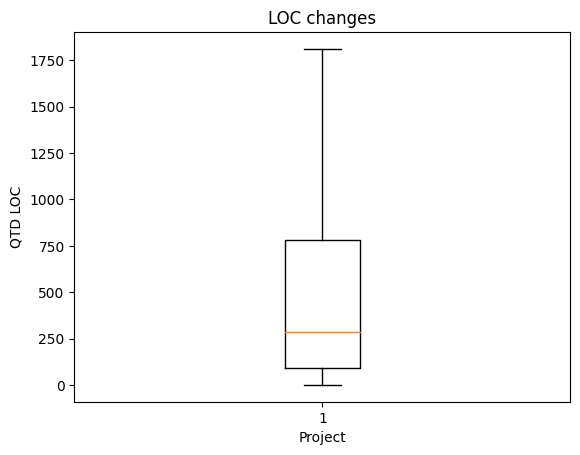

In [39]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('LOC changes')
ax1.set_xlabel('Project')
ax1.set_ylabel('QTD LOC')
ax1.boxplot(x=df_commit_diffs_satd.lines, showfliers=False)

In [40]:
round(df_commit_diffs_satd.lines.describe(), 2)

count     3232.00
mean       692.32
std       1728.62
min          1.00
25%         93.00
50%        284.00
75%        780.50
max      72944.00
Name: lines, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7ca1da7f5420>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca1da7f7b20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca1da7f4e20>],
 'medians': [<matplotlib.lines.Line2D at 0x7ca1da7f7700>],
 'fliers': [],
 'means': []}

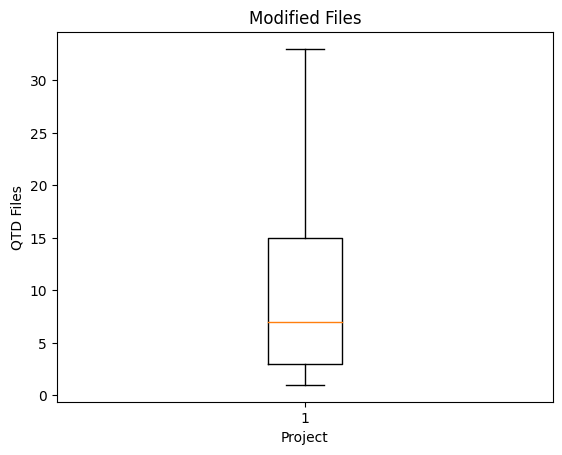

In [41]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('Modified Files')
ax1.set_xlabel('Project')
ax1.set_ylabel('QTD Files')
ax1.boxplot(x=df_commit_diffs_satd.files, showfliers=False)

In [42]:
round(df_commit_diffs_satd.files.describe(), 2)

count    3232.00
mean       13.30
std        20.76
min         1.00
25%         3.00
50%         7.00
75%        15.00
max       433.00
Name: files, dtype: float64

In [43]:
df_commit_diffs_satd.to_excel('kafka_diffs_satd.xlsx', index=False)

### Commits with Critical Classes diffs with SATD

In [44]:
print('Conjunto de commits com classes críticas: ')
print(f'{len(set_only_commits_critical_classes)}')

Conjunto de commits com classes críticas: 
1452


In [45]:
df_commits_with_critical_classes_with_satd = df_commit_diffs_satd[df_commit_diffs_satd.commit.isin(set_only_commits_critical_classes)]
df_commits_with_critical_classes_with_satd

,commit,msg,lines,files,keywords,comments
140,269d16d3c915d09f650ae32aa81542bd8522ca68,KAFKA-1227 New producer!,11720,121,"[exception, interface, performance, leak, docu...",[ * This exception is thrown if the producer i...
141,253f86e31062fb86401abdc13835c251eef47417,Implement a few of the API suggestions from th...,1293,38,"[handling, exception, leak, exception, excepti...",[ * A callback method the user can impleme...
142,fa6339c19cd06880d32ec9a5ee6b66e7f1488dcf,Rename client package from kafka.* to org.apac...,803,116,[interface],[ * This is the interface used for most of the...
153,3f0b67b6ac864befccfdd4bb5dee08c0b33c3b43,KAFKA-1252 Implement retries in new producer.,1053,23,"[update, unused, exception, exception, exception]","[ * The last time metadata was updated., ..."
155,5e2a9a560d847bd0cf364d86bd6784f70d99c71a,KAFKA-1260 Integration Test for New Producer P...,507,14,"[exception, API, exception, TODO, TODO, update...",[ // For API exceptions return them...
...,...,...,...,...,...,...
3187,b49013b73efa25466652d8d8122974e60c927ec4,KAFKA-9800: Exponential backoff for Kafka clie...,981,60,"[update, clean, update, update, not used, upda...","[ * Increment the failure counter, update ..."
3212,e1dc6d9f3493eb35e3d3eef1d70c2d1fc94d74c2,KAFKA-14274 [2-5/7]: Introduction of more infr...,3079,36,"[test, test, test, test, update, update, excep...",[ // This is the test that returns true...
3213,1c402297d60152722cf5544a14ca5271d576d55e,KAFKA-15306 - Integrating committed offsets fo...,234,4,"[update, update, update, not used]",[ * @param metadata Metadata obj...
3225,079e5d647ce39cf2ab5b5f37c5ce28b59fb6db13,KAFKA-15326: [8/N] Move consumer interaction o...,320,14,[test],[ // for testing only]


In [46]:
round(df_commits_with_critical_classes_with_satd.describe(), 2)

,lines,files
count,702.00,702.00
mean,903.89,19.78
std,1414.09,23.18
min,2.00,1.00
25%,175.00,6.00
50%,453.00,12.00
75%,1070.00,24.00
max,16103.00,197.00


## Analisa Commits sem SATD

### Analisa todos os diffs (added) dos commits entre 1/08/2011 e 4/10/2023 do Kafka que SEM as SATD.

In [47]:
dict_commit_diffs_no_satd = my_satd_commit_analyzer.analyze_commit_diffs_for_no_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress SATD diff commit analysis: 100%|██████████| 11732/11732 [05:56<00:00, 32.89it/s]


In [48]:
df_commit_diffs_no_satd = create_df_commits_diffs_no_satd(dict_commit_diffs_no_satd)

In [49]:
df_commit_diffs_no_satd

,commits,msg,lines,files,comments
0,642da2f28c9bc6e373603d6d9119ce33684090f5,Initial checkin of Kafka to Apache SVN. This c...,72944,433,[* Support for parallel data load into Hadoop....
1,cbbfbaf33179f2a44ae641ccaaba1f0a8e73730f,gitignore for git-svn users.\n\n\ngit-svn-id: ...,14,1,"[*classes, *~, *#]"
2,e96cf1facfa4ef21128f38aaf9484a307c6bdb61,Update readme links.\n\n\ngit-svn-id: https://...,9,1,[ * svn co http://svn.apache.org/repos/asf/inc...
3,462dfda513d98a0017564f5070f678d57f834872,KAFKA-93 | Change and add ASF source header to...,2468,188,"[/**, * Licensed to the Apache Software Found..."
4,d0c980dab278627286e9a2be649de0f6c8ce8b53,KAFKA-93 | add license to missed files and rem...,120,10,[ * Licensed to the Apache Software Foundation...
...,...,...,...,...,...
5892,f5a7491da607644590f4421ef37d4a7bf2d3ea10,MINOR: Correcting Javadocs for throwIfMemberEp...,6,1,[ * @throws FencedMemberEpochException if ...
5893,6263197a62389c9dce0210cd9d65a6e601345edc,KAFKA-15326: [9/N] Start and stop executors an...,379,9,[ // flush the task before giving i...
5894,b6c7855475397166c4fbc79071b4aa93696519e5,KAFKA-15449: Verify transactional offset commi...,150,13,[ * - {@link Errors#INVALID_PRODUCER_ID_MAPP...
5895,8f8dbad564ffd9be409bb85edadbc40659cd0a56,KAFKA-14595 ReassignPartitionsIntegrationTest ...,1680,7,[ /** @see TestInfoUtils#TestWithParameteri...


In [50]:
round(df_commit_diffs_no_satd.describe(), 2)

,lines,files
count,5897.00,5897.00
mean,483.27,10.63
std,1438.45,22.94
min,1.00,1.00
25%,55.00,2.00
50%,161.00,5.00
75%,481.00,11.00
max,72944.00,1100.00


In [51]:
df_commit_diffs_no_satd.to_excel('kafka_commit_diffs_no_satd.xlsx', index=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ca1d9bc66b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca1d9c56ec0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca1d9bc4370>],
 'medians': [<matplotlib.lines.Line2D at 0x7ca1d9c542e0>],
 'fliers': [],
 'means': []}

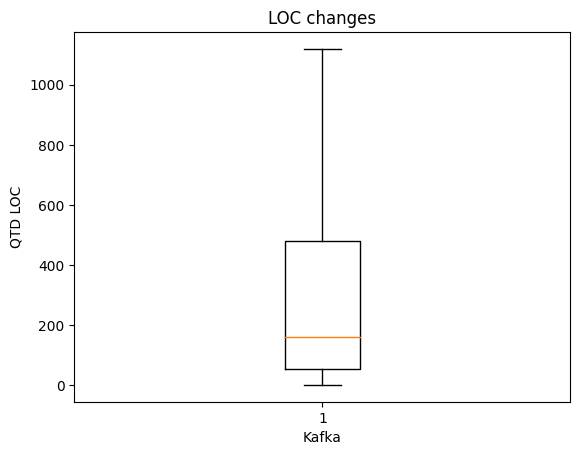

In [52]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('LOC changes')
ax1.set_xlabel('Kafka')
ax1.set_ylabel('QTD LOC')
ax1.boxplot(x=df_commit_diffs_no_satd.lines, showfliers=False)

In [53]:
round(df_commit_diffs_no_satd.lines.describe(), 2)

count     5897.00
mean       483.27
std       1438.45
min          1.00
25%         55.00
50%        161.00
75%        481.00
max      72944.00
Name: lines, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7ca1d9c69f90>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca1d9c6add0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca1d9c6ae00>],
 'medians': [<matplotlib.lines.Line2D at 0x7ca1d9c69fc0>],
 'fliers': [],
 'means': []}

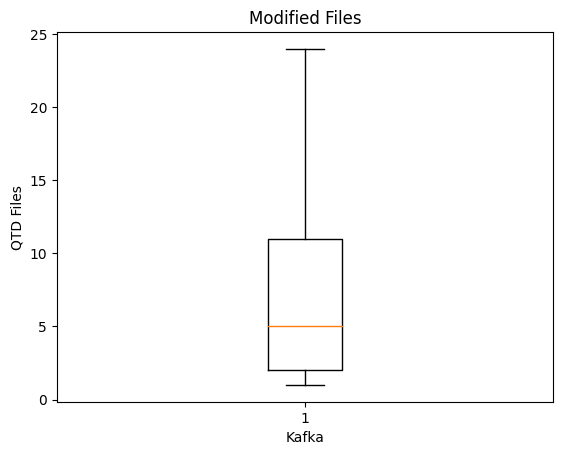

In [54]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('Modified Files')
ax1.set_xlabel('Kafka')
ax1.set_ylabel('QTD Files')
ax1.boxplot(x=df_commit_diffs_no_satd.files, showfliers=False)

In [55]:
round(df_commit_diffs_no_satd.files.describe(), 2)

count    5897.00
mean       10.63
std        22.94
min         1.00
25%         2.00
50%         5.00
75%        11.00
max      1100.00
Name: files, dtype: float64

In [56]:
df_commits_with_critical_classes_no_satd = df_commit_diffs_no_satd[df_commit_diffs_no_satd.commits.isin(set_only_commits_critical_classes)]
df_commits_with_critical_classes_no_satd

,commits,msg,lines,files,comments
313,269d16d3c915d09f650ae32aa81542bd8522ca68,KAFKA-1227 New producer!,11720,121,"[/**, * which data can be sent for long enoug..."
315,253f86e31062fb86401abdc13835c251eef47417,Implement a few of the API suggestions from th...,1293,38,[ * will generally execute in the background I...
317,fa6339c19cd06880d32ec9a5ee6b66e7f1488dcf,Rename client package from kafka.* to org.apac...,803,116,[ * This class acts as a queue that accumulate...
321,36eae8f63c81f8d38c2351054c15bf7d5eb612d9,trivial fix to add missing license header usin...,2020,125,"[/**, * Licensed to the Apache Software Found..."
331,7e154a36f74ad0ea7e0f6d48b71a5a73d99330e7,KAFKA-1261 Make it possible to configure the m...,67,2,[ * Licensed to the Apache Software Foundation...
...,...,...,...,...,...
5851,01b91af59cb08b843470742a7a25d1f4239ebf45,MINOR: fix currentLag javadoc (#14224)\n\nRevi...,3,1,[ * This method uses locally cached metada...
5867,e1dc6d9f3493eb35e3d3eef1d70c2d1fc94d74c2,KAFKA-14274 [2-5/7]: Introduction of more infr...,3079,36,"[ /**, * Initiate a connection if curr..."
5869,1c402297d60152722cf5544a14ca5271d576d55e,KAFKA-15306 - Integrating committed offsets fo...,234,4,[ * Refresh the committed offsets for part...
5885,079e5d647ce39cf2ab5b5f37c5ce28b59fb6db13,KAFKA-15326: [8/N] Move consumer interaction o...,320,14,"[ // noop, // noop, /**, ..."


In [57]:
round(df_commits_with_critical_classes_no_satd.describe(), 2)

,lines,files
count,1125.00,1125.00
mean,675.87,17.09
std,1256.55,38.57
min,1.00,1.00
25%,93.00,4.00
50%,293.00,9.00
75%,744.00,20.00
max,16103.00,1100.00


# Comparing Commits with SATD and Commits without SATD

## Geral


In [136]:
df_commit_diffs_satd.to_excel('kafka_commit_diffs_satd.xlsx', index=False)
df_commit_diffs_no_satd.to_excel('kafka_commit_diffs_no_satd.xlsx', index=False)

### LOC changes

<ipython-input-137-fa6de1c5cdbd>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7ca1d9b61360>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca1db014c40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca1d9d30160>,
 'medians': [<matplotlib.lines.Line2D at 0x7ca1db017730>,
 'fliers': [],
 'means': []}

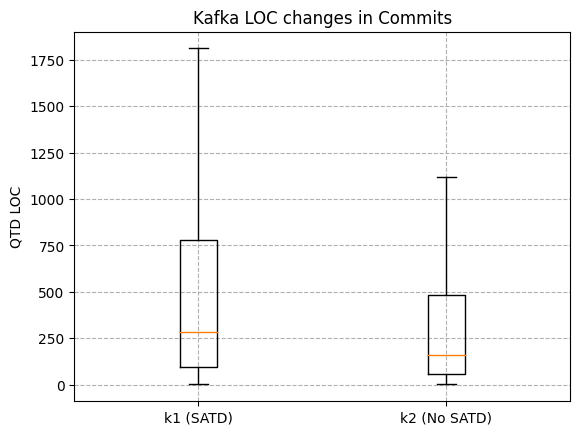

In [137]:
data_lines = [df_commit_diffs_satd.lines, df_commit_diffs_no_satd.lines]
fig1, ax1 = pyplot.subplots()
ax1.set_title('Kafka LOC changes in Commits')
ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_lines, showfliers=False)

In [138]:
fig1.savefig('kafka1.png')
Image1 = cv2.imread('kafka1.png')
list_figures.append(Image1)

### Modified Files

<ipython-input-139-d6caa26e4b6e>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7ca1daf12d70>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca1daf10e20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca1daf13d60>,
 'medians': [<matplotlib.lines.Line2D at 0x7ca1d9b2f4f0>,
 'fliers': [],
 'means': []}

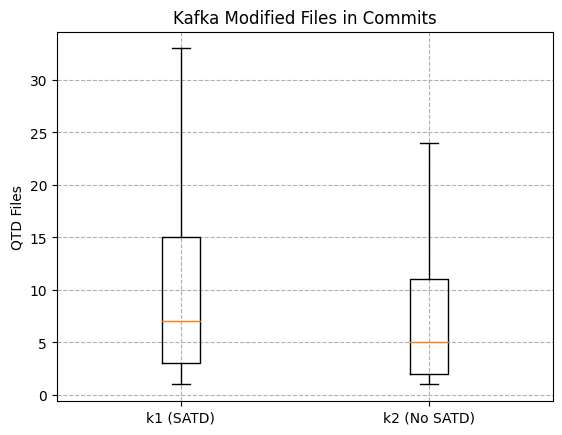

In [139]:
data_files = [df_commit_diffs_satd.files, df_commit_diffs_no_satd.files]
fig1, ax1 = pyplot.subplots()
ax1.set_title('Kafka Modified Files in Commits')
ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])
ax1.set_ylabel('QTD Files')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_files, showfliers=False)

In [140]:
fig1.savefig('kafka2.png')
Image2 = cv2.imread('kafka2.png')
list_figures.append(Image2)

## Commits with Critical Classes

### Geral

In [141]:
df_commits_with_critical_classes_with_satd.to_excel('kafka_commits_with_critical_classes_with_satd.xlsx', index=False)
df_commits_with_critical_classes_no_satd.to_excel('kafka_commits_with_critical_classes_no_satd.xlsx', index=False)

**LOC changes**

<ipython-input-142-9c5489421084>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7ca1d219e320>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca1d2164be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca1d0fffaf0>,
 'medians': [<matplotlib.lines.Line2D at 0x7ca1dc7ce560>,
 'fliers': [],
 'means': []}

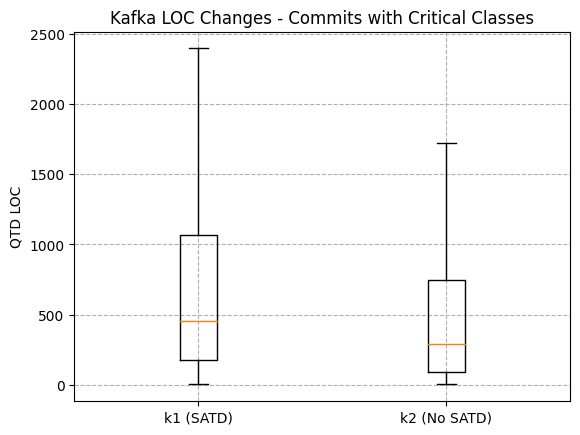

In [142]:
data_commits_cc_lines = df_commits_with_critical_classes_with_satd.lines, df_commits_with_critical_classes_no_satd.lines
fig1, ax1 = pyplot.subplots()
ax1.set_title('Kafka LOC Changes - Commits with Critical Classes')
ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_commits_cc_lines, showfliers=False)

In [143]:
fig1.savefig('kafka3.png')
Image3 = cv2.imread('kafka3.png')
list_figures.append(Image3)

**Modified files**

<ipython-input-144-11e5feecfce2>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7ca1d45e03a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca1d45e08e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca1d45e0100>,
 'medians': [<matplotlib.lines.Line2D at 0x7ca1d45e0e20>,
 'fliers': [],
 'means': []}

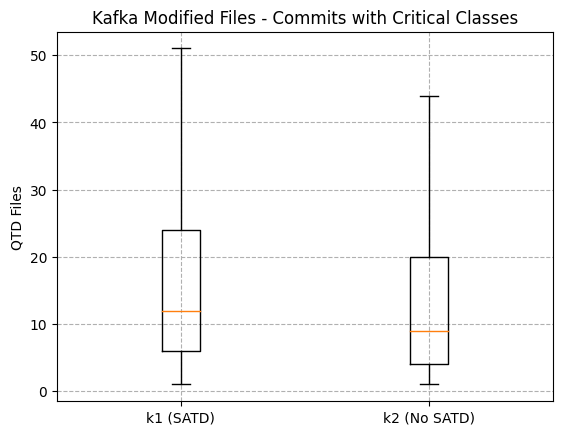

In [144]:
data_commits_cc_files = df_commits_with_critical_classes_with_satd.files, df_commits_with_critical_classes_no_satd.files
fig1, ax1 = pyplot.subplots()
ax1.set_title('Kafka Modified Files - Commits with Critical Classes')
ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])
ax1.set_ylabel('QTD Files')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_commits_cc_files, showfliers=False)

In [145]:
fig1.savefig('kafka4.png')
Image4 = cv2.imread('kafka4.png')
list_figures.append(Image4)

### Issues in commits

In [146]:
df_issues_in_commits_with_critical_classes_with_satd = df_commits_with_critical_classes_with_satd[df_commits_with_critical_classes_with_satd.commit.isin(list_commits_with_critical_classes_with_issues)]
df_issues_in_commits_with_critical_classes_with_satd

,commit,msg,lines,files,keywords,comments
140,269d16d3c915d09f650ae32aa81542bd8522ca68,KAFKA-1227 New producer!,11720,121,"[exception, interface, performance, leak, docu...",[ * This exception is thrown if the producer i...
153,3f0b67b6ac864befccfdd4bb5dee08c0b33c3b43,KAFKA-1252 Implement retries in new producer.,1053,23,"[update, unused, exception, exception, exception]","[ * The last time metadata was updated., ..."
155,5e2a9a560d847bd0cf364d86bd6784f70d99c71a,KAFKA-1260 Integration Test for New Producer P...,507,14,"[exception, API, exception, TODO, TODO, update...",[ // For API exceptions return them...
156,f1a53b972eb1f8e75db54d3272d9eb7c398e238a,KAFKA-1250 Add logging to new producer.,464,18,[unused],[ /* configs for which values have been req...
160,466a83b78c2bfcb9ac3116748394e7845a99bf7a,KAFKA-1253 Compression in the new producer; re...,545,19,"[exception, header, constructor, constructor, ...",[ * @param exception The exception returne...
...,...,...,...,...,...,...
3187,b49013b73efa25466652d8d8122974e60c927ec4,KAFKA-9800: Exponential backoff for Kafka clie...,981,60,"[update, clean, update, update, not used, upda...","[ * Increment the failure counter, update ..."
3212,e1dc6d9f3493eb35e3d3eef1d70c2d1fc94d74c2,KAFKA-14274 [2-5/7]: Introduction of more infr...,3079,36,"[test, test, test, test, update, update, excep...",[ // This is the test that returns true...
3213,1c402297d60152722cf5544a14ca5271d576d55e,KAFKA-15306 - Integrating committed offsets fo...,234,4,"[update, update, update, not used]",[ * @param metadata Metadata obj...
3225,079e5d647ce39cf2ab5b5f37c5ce28b59fb6db13,KAFKA-15326: [8/N] Move consumer interaction o...,320,14,[test],[ // for testing only]


In [147]:
round(df_issues_in_commits_with_critical_classes_with_satd.describe(), 2)

,lines,files
count,593.00,593.00
mean,977.67,20.53
std,1445.97,22.98
min,4.00,1.00
25%,226.00,6.00
50%,495.00,13.00
75%,1132.00,25.00
max,16103.00,197.00


In [148]:
df_issues_in_commits_with_critical_classes_with_satd.to_excel('kafka_issues_in_commits_with_critical_classes_with_satd.xlsx', index=False)

In [149]:
df_issues_in_commits_with_critical_classes_no_satd = df_commits_with_critical_classes_no_satd[df_commits_with_critical_classes_no_satd.commits.isin(list_commits_with_critical_classes_with_issues)]
df_issues_in_commits_with_critical_classes_no_satd

,commits,msg,lines,files,comments
313,269d16d3c915d09f650ae32aa81542bd8522ca68,KAFKA-1227 New producer!,11720,121,"[/**, * which data can be sent for long enoug..."
331,7e154a36f74ad0ea7e0f6d48b71a5a73d99330e7,KAFKA-1261 Make it possible to configure the m...,67,2,[ * Licensed to the Apache Software Foundation...
333,3f0b67b6ac864befccfdd4bb5dee08c0b33c3b43,KAFKA-1252 Implement retries in new producer.,1053,23,[ * preference specified by {@link #BLOCK_...
336,5e2a9a560d847bd0cf364d86bd6784f70d99c71a,KAFKA-1260 Integration Test for New Producer P...,507,14,[ // ignore the relativeOffset if the b...
337,f1a53b972eb1f8e75db54d3272d9eb7c398e238a,KAFKA-1250 Add logging to new producer.,464,18,[ * Licensed to the Apache Software Foundation...
...,...,...,...,...,...
5836,b49013b73efa25466652d8d8122974e60c927ec4,KAFKA-9800: Exponential backoff for Kafka clie...,981,60,[ * Up to a (pre-jitter) maximum of socket...
5867,e1dc6d9f3493eb35e3d3eef1d70c2d1fc94d74c2,KAFKA-14274 [2-5/7]: Introduction of more infr...,3079,36,"[ /**, * Initiate a connection if curr..."
5869,1c402297d60152722cf5544a14ca5271d576d55e,KAFKA-15306 - Integrating committed offsets fo...,234,4,[ * Refresh the committed offsets for part...
5885,079e5d647ce39cf2ab5b5f37c5ce28b59fb6db13,KAFKA-15326: [8/N] Move consumer interaction o...,320,14,"[ // noop, // noop, /**, ..."


In [150]:
round(df_issues_in_commits_with_critical_classes_no_satd.describe(), 2)

,lines,files
count,906.00,906.00
mean,737.27,16.89
std,1231.32,20.53
min,1.00,1.00
25%,135.00,5.00
50%,350.50,10.00
75%,835.25,21.00
max,16103.00,197.00


In [151]:
df_issues_in_commits_with_critical_classes_no_satd.to_excel('kafka_issues_in_commits_with_critical_classes_no_satd.xlsx', index=False)

**LOC changes**

<ipython-input-152-9fb412b1d6a8>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7ca1d672fa00>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca1d672ff40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca1d672f820>,
 'medians': [<matplotlib.lines.Line2D at 0x7ca1d67004c0>,
 'fliers': [],
 'means': []}

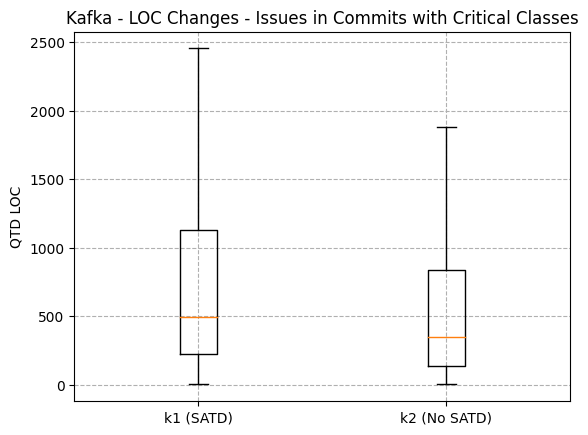

In [152]:
data_issues_commits_cc_lines = df_issues_in_commits_with_critical_classes_with_satd.lines, df_issues_in_commits_with_critical_classes_no_satd.lines
fig1, ax1 = pyplot.subplots()
ax1.set_title('Kafka - LOC Changes - Issues in Commits with Critical Classes')
ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_issues_commits_cc_lines, showfliers=False)

In [153]:
fig1.savefig('kafka5.png')
Image5 = cv2.imread('kafka5.png')
list_figures.append(Image5)

**Modified Files**

<ipython-input-154-eaed560b7ba3>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7ca1d313ab90>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca1d313b0d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca1d313a8f0>,
 'medians': [<matplotlib.lines.Line2D at 0x7ca1d313b610>,
 'fliers': [],
 'means': []}

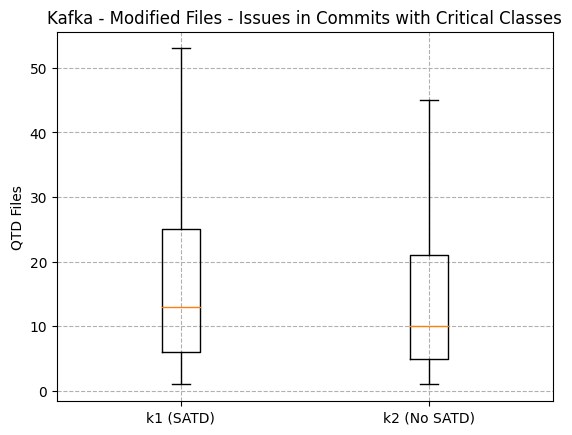

In [154]:
data_issues_commits_cc_files = df_issues_in_commits_with_critical_classes_with_satd.files, df_issues_in_commits_with_critical_classes_no_satd.files
fig1, ax1 = pyplot.subplots()
ax1.set_title('Kafka - Modified Files - Issues in Commits with Critical Classes')
ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])
ax1.set_ylabel('QTD Files')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_issues_commits_cc_files, showfliers=False)

In [155]:
fig1.savefig('kafka6.png')
Image6 = cv2.imread('kafka6.png')
list_figures.append(Image6)

## Commits without Critical Classes

In [156]:
print('Commits sem classes críticas: ', len(list_commits_no_critical_classes))

Commits sem classes críticas:  10280


In [157]:
dict_commits_no_critical_classes = {}
for k, v in all_commits.items():
  if k in list_commits_no_critical_classes:
    dict_commits_no_critical_classes[k] = v

print(len(dict_commits_no_critical_classes))

10280


In [158]:
df_commits_no_critical_classes = convert_commits_to_dataframe2(dict_commits_no_critical_classes)
df_commits_no_critical_classes

,hash,msg,date,lines,files,modified_files,diff_modified_files
0,642da2f28c9bc6e373603d6d9119ce33684090f5,Initial checkin of Kafka to Apache SVN. This c...,1/8/2011,72944,433,"[CONTRIBUTORS, LICENSE, NOTICE, README.md, kaf...","[{'CONTRIBUTORS': '@@ -0,0 +1,10 @@ +Jay Kreps..."
1,cbbfbaf33179f2a44ae641ccaaba1f0a8e73730f,gitignore for git-svn users.\n\n\ngit-svn-id: ...,3/8/2011,14,1,[.gitignore],"[{'.gitignore': '@@ -0,0 +1,14 @@ +dist +*clas..."
2,665f1d0527846e1eaf6c39fd8a329dbfeb08b0c9,upgrade zkclient jar; #KAFKA-82\n\ngit-svn-id:...,5/8/2011,0,1,[zkclient-20110412.jar],[{'zkclient-20110412.jar': 'Binary files a/cor...
3,96b8e03dd1ee23a550ca87803777b4d7bec05d5a,commit offset before consumer shutdown KAFKA-8...,7/8/2011,64,11,"[ConsoleConsumer.scala, ZookeeperConsumerConne...","[{'ConsoleConsumer.scala': '@@ -28,7 +28,7 @@ ..."
4,f7046c247dd466c90337bb39a4612115c3e41923,Options in SyncProducerConfig and AsyncProduce...,7/8/2011,17,1,[ProducerPool.scala],"[{'ProducerPool.scala': '@@ -69,24 +69,15 @@ c..."
...,...,...,...,...,...,...,...
10275,8f8dbad564ffd9be409bb85edadbc40659cd0a56,KAFKA-14595 ReassignPartitionsIntegrationTest ...,2/10/2023,1680,7,"[build.gradle, import-control.xml, ClusterConf...","[{'build.gradle': '@@ -1911,6 +1911,7 @@ proje..."
10276,7553d3f562f3af6c7f9b062b9220bcad80b00478,KAFKA-14593: Move LeaderElectionCommand to too...,3/10/2023,1432,10,"[kafka-leader-election.sh, kafka-leader-electi...","[{'kafka-leader-election.sh': '@@ -14,4 +14,4 ..."
10277,951a9fef9d44fe74c613cef369589ec214f70e33,MINOR: Upgrade zstd-jni to 1.5.5-6 (#14449)\n\...,3/10/2023,4,2,"[LICENSE-binary, dependencies.gradle]","[{'LICENSE-binary': '@@ -318,7 +318,7 @@ pcoll..."
10278,5f676cce7a6b695e07a7cd1d0ac2ca41960780ae,KAFKA-15483: Add KIP-938 and KIP-866 metrics t...,3/10/2023,60,1,[ops.html],"[{'ops.html': '@@ -1980,6 +1980,28 @@ These me..."


In [159]:
round(df_commits_no_critical_classes.describe(), 2)

,lines,files
count,10280.00,10280.00
mean,248.33,6.05
std,1235.39,15.25
min,0.00,0.00
25%,8.00,1.00
50%,40.00,2.00
75%,162.00,5.00
max,72944.00,498.00


In [160]:
df_commits_no_critical_classes.to_excel('kafka_commits_no_critical_classes.xlsx', index=False)

In [161]:
list_commits_no_critical_classes = df_commits_no_critical_classes.hash.to_list()
print(len(list_commits_no_critical_classes))

10280


### Commits sem critical classes com SATD

In [162]:
df_commits_without_critical_classes_with_satd = df_commit_diffs_satd[df_commit_diffs_satd.commit.isin(list_commits_no_critical_classes)]
df_commits_without_critical_classes_with_satd

,commit,msg,lines,files,keywords,comments
0,642da2f28c9bc6e373603d6d9119ce33684090f5,Initial checkin of Kafka to Apache SVN. This c...,72944,433,"[performance, throughput, support for, files, ...",[* Persistent messaging with O(1) disk structu...
1,28984e6c1834bd88f5acb86dd7468751c542ac50,Some new unit tests for ByteBufferMessageSet i...,77,2,"[test, test, test, test]",[ // test for uncompressed regular messages...
2,bf30ae996f2ec08ae97f61a0eff0c50bb8ce8067,The FetcherRunnable busy waits on empty fetch ...,43,3,[test],[ // test valid bytes on empty ByteBufferMe...
3,c247dfa8844f6d112755f21918dc1515db37a05e,KAFKA-124 Console consumer does not stop consu...,13,1,[output],[ // This means no one is listening t...
4,54f49314afbc1e13ff511f152e9b292ffaf9104d,KAFKA-70 Patch from Prashanth Menon to add spa...,113,3,"[clean, cleanup]",[ // this cleanup shouldn't find any expire...
...,...,...,...,...,...,...
3226,fcac880fd54efbec3fe385000cf990a19972dafa,KAFKA-15466: Add KIP-919 support for some admi...,1969,44,"[exception, test]","[ * If this is non-null, it is a fatal exc..."
3227,86450bf9aca481113fadbb0ecf0eb4b180762a30,KAFKA-15498: bump snappy-java version to 1.1.1...,71,4,"[header, header, header, header, header, heade...",[ // 1. send message without key and he...
3228,13b119aa62bb654eed9e6ac3235dd4f242d11636,KAFKA-15511: Handle CorruptIndexException in R...,31,2,[files],[ // assert that parent directory for the i...
3230,8f8dbad564ffd9be409bb85edadbc40659cd0a56,KAFKA-14595 ReassignPartitionsIntegrationTest ...,1680,7,"[API, test, test, update, output, test]",[ // the `AlterPartition` API. In this ...


In [163]:
round(df_commits_without_critical_classes_with_satd.describe(), 2)

,lines,files
count,2530.00,2530.00
mean,633.62,11.50
std,1802.07,19.67
min,1.00,1.00
25%,80.00,2.00
50%,241.00,5.50
75%,710.00,13.00
max,72944.00,433.00


In [164]:
df_commits_without_critical_classes_with_satd.to_excel('kafka_commits_without_critical_classes_with_satd.xlsx', index=False)

### Commits sem critical classes e sem SATD

In [165]:
df_commits_without_critical_classes_no_satd = df_commit_diffs_no_satd[df_commit_diffs_no_satd.commits.isin(list_commits_no_critical_classes)]
df_commits_without_critical_classes_no_satd

,commits,msg,lines,files,comments
0,642da2f28c9bc6e373603d6d9119ce33684090f5,Initial checkin of Kafka to Apache SVN. This c...,72944,433,[* Support for parallel data load into Hadoop....
1,cbbfbaf33179f2a44ae641ccaaba1f0a8e73730f,gitignore for git-svn users.\n\n\ngit-svn-id: ...,14,1,"[*classes, *~, *#]"
2,e96cf1facfa4ef21128f38aaf9484a307c6bdb61,Update readme links.\n\n\ngit-svn-id: https://...,9,1,[ * svn co http://svn.apache.org/repos/asf/inc...
3,462dfda513d98a0017564f5070f678d57f834872,KAFKA-93 | Change and add ASF source header to...,2468,188,"[/**, * Licensed to the Apache Software Found..."
4,d0c980dab278627286e9a2be649de0f6c8ce8b53,KAFKA-93 | add license to missed files and rem...,120,10,[ * Licensed to the Apache Software Foundation...
...,...,...,...,...,...
5891,13b119aa62bb654eed9e6ac3235dd4f242d11636,KAFKA-15511: Handle CorruptIndexException in R...,31,2,"[ // create Corrupt Offset Index File, ..."
5892,f5a7491da607644590f4421ef37d4a7bf2d3ea10,MINOR: Correcting Javadocs for throwIfMemberEp...,6,1,[ * @throws FencedMemberEpochException if ...
5894,b6c7855475397166c4fbc79071b4aa93696519e5,KAFKA-15449: Verify transactional offset commi...,150,13,[ * - {@link Errors#INVALID_PRODUCER_ID_MAPP...
5895,8f8dbad564ffd9be409bb85edadbc40659cd0a56,KAFKA-14595 ReassignPartitionsIntegrationTest ...,1680,7,[ /** @see TestInfoUtils#TestWithParameteri...


In [166]:
round(df_commits_without_critical_classes_no_satd.describe(), 2)

,lines,files
count,4772.00,4772.00
mean,437.87,9.11
std,1474.53,16.97
min,1.00,1.00
25%,50.00,2.00
50%,141.50,4.00
75%,417.00,10.00
max,72944.00,433.00


In [167]:
df_commits_without_critical_classes_no_satd.to_excel('kafka_commits_without_critical_classes_no_satd.xlsx', index=False)

### Testes dos commits sem critical classes

**LOC changes**

<ipython-input-168-4c2cf472d551>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7ca1d3d074f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca1d3d07a30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca1d3d07250>,
 'medians': [<matplotlib.lines.Line2D at 0x7ca1d3d07f70>,
 'fliers': [],
 'means': []}

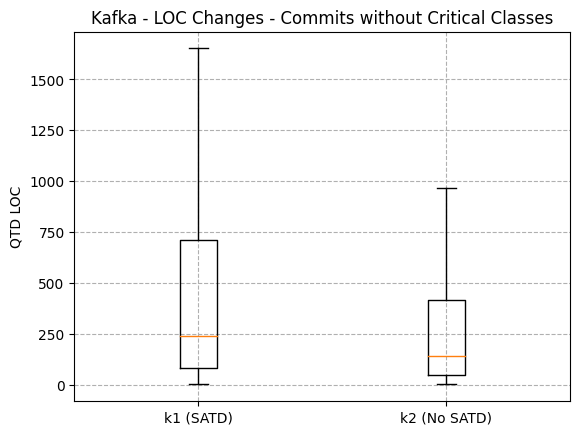

In [168]:
data_commits_no_cc_lines = df_commits_without_critical_classes_with_satd.lines, df_commits_without_critical_classes_no_satd.lines

fig1, ax1 = pyplot.subplots()

ax1.set_title('Kafka - LOC Changes - Commits without Critical Classes')
ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_commits_no_cc_lines, showfliers=False)

In [169]:
fig1.savefig('kafka7.png')
Image7 = cv2.imread('kafka7.png')
list_figures.append(Image7)

**Modified Files**

<ipython-input-170-6bc7d64811cc>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7ca1d6a5f4c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca1d6a5e6e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca1d6a5f220>,
 'medians': [<matplotlib.lines.Line2D at 0x7ca1d6a5d120>,
 'fliers': [],
 'means': []}

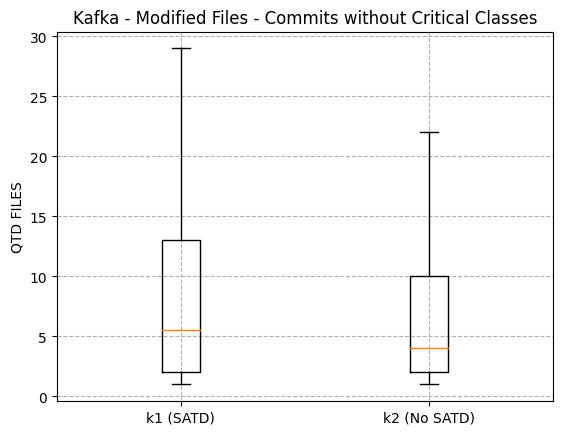

In [170]:
data_commits_no_cc_files = df_commits_without_critical_classes_with_satd.files, df_commits_without_critical_classes_no_satd.files

fig1, ax1 = pyplot.subplots()

ax1.set_title('Kafka - Modified Files - Commits without Critical Classes')
ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])
ax1.set_ylabel('QTD FILES')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_commits_no_cc_files, showfliers=False)

In [171]:
fig1.savefig('kafka8.png')
Image8 = cv2.imread('kafka8.png')
list_figures.append(Image8)

# Comparing Boxsplot of Commits with SATD and Commits without SATD

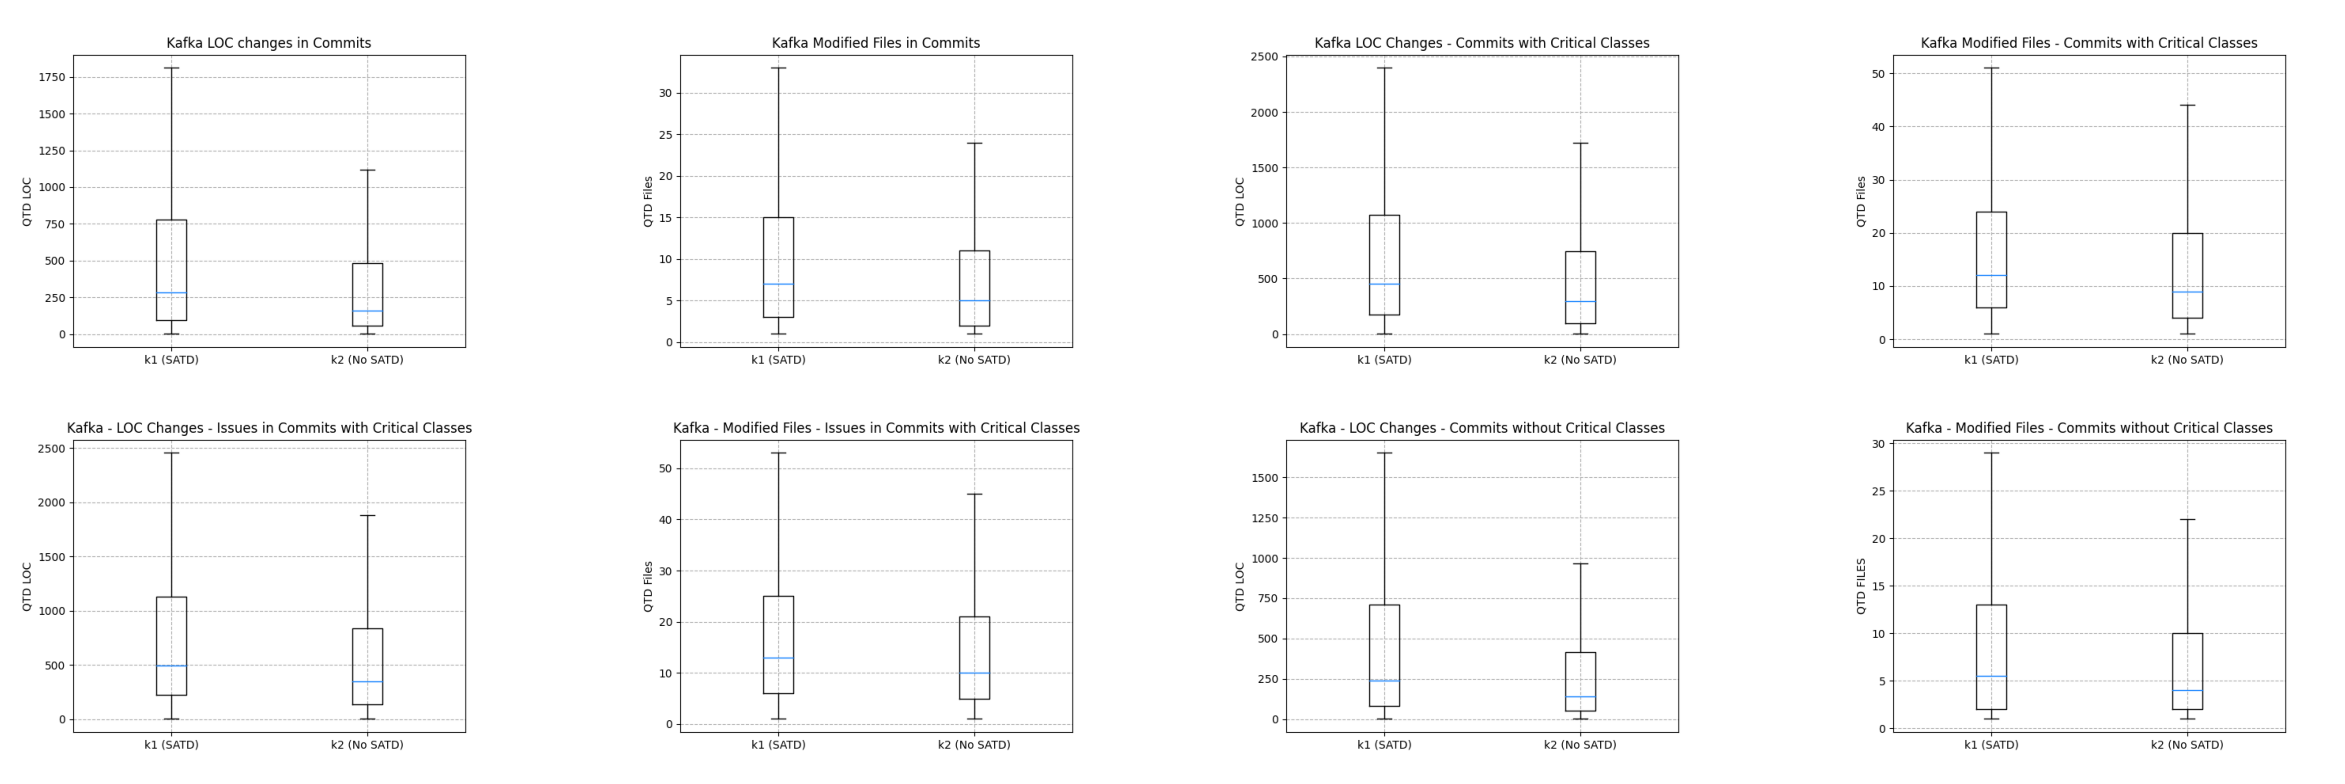

In [172]:
my_figures(lista_imagens=list_figures, my_h=30, my_w=10, my_hspace=0, my_wspace=0.2)

In [130]:
!ls *.xlsx

kafka_all_issues_in_commits.xlsx
kafka_commit_diffs_no_satd.xlsx
kafka_commit_diffs_satd.xlsx
kafka_commits_no_critical_classes.xlsx
kafka_commits_with_critical_classes_no_satd.xlsx
kafka_commits_with_critical_classes_with_satd.xlsx
kafka_commits_with_critical_classes.xlsx
kafka_commits_without_critical_classes_no_satd.xlsx
kafka_commits_without_critical_classes_with_satd.xlsx
kafka_diffs_satd.xlsx
kafka_issues_in_commits_with_critical_classes_no_satd.xlsx
kafka_issues_in_commits_with_critical_classes_with_satd.xlsx
kafka_issues_in_commits_with_critical_classes.xlsx


In [134]:
!zip -r my_kafka_excel.zip *.xlsx

  adding: kafka_all_issues_in_commits.xlsx (deflated 1%)
  adding: kafka_commit_diffs_no_satd.xlsx (deflated 0%)
  adding: kafka_commit_diffs_satd.xlsx (deflated 0%)
  adding: kafka_commits_no_critical_classes.xlsx (deflated 0%)
  adding: kafka_commits_with_critical_classes_no_satd.xlsx (deflated 0%)
  adding: kafka_commits_with_critical_classes_with_satd.xlsx (deflated 0%)
  adding: kafka_commits_with_critical_classes.xlsx (deflated 0%)
  adding: kafka_commits_without_critical_classes_no_satd.xlsx (deflated 0%)
  adding: kafka_commits_without_critical_classes_with_satd.xlsx (deflated 0%)
  adding: kafka_diffs_satd.xlsx (deflated 0%)
  adding: kafka_issues_in_commits_with_critical_classes_no_satd.xlsx (deflated 0%)
  adding: kafka_issues_in_commits_with_critical_classes_with_satd.xlsx (deflated 0%)
  adding: kafka_issues_in_commits_with_critical_classes.xlsx (deflated 1%)


In [132]:
!ls -l *.zip

-rw-r--r-- 1 root root 40816542 Nov 24 18:28 my_kafka_excel.zip
